In [192]:
#import mavenn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression
from os.path import exists




In [ ]:
df_mapped = pd.read_csv("../../../data/barcodes/20220514_mapping/mapped_barcodes.csv", delim_whitespace=True)

In [176]:
promoter_names = df_mapped.name.unique()
def find_promoter(name):
    ind = [name in x for x in promoter_names]
    return promoter_names[ind][0]

In [175]:
"cpxR" in "cpxRp2"

True

In [195]:
for promoter in promoter_names:
    make_footprints(promoter, [])

/tmp/ipykernel_35002/3734758959.py:7: RuntimeWarning: invalid value encountered in double_scalars
  I[i] = np.sum([p[m, mu, i] * np.log2(p[m, mu, i] / p_m[m] / p_mu[mu]) for mu in [0, 1] for m in [0, 1]])
/tmp/ipykernel_35002/3734758959.py:7: RuntimeWarning: invalid value encountered in double_scalars
  I[i] = np.sum([p[m, mu, i] * np.log2(p[m, mu, i] / p_m[m] / p_mu[mu]) for mu in [0, 1] for m in [0, 1]])
/tmp/ipykernel_35002/3734758959.py:7: RuntimeWarning: invalid value encountered in double_scalars
  I[i] = np.sum([p[m, mu, i] * np.log2(p[m, mu, i] / p_m[m] / p_mu[mu]) for mu in [0, 1] for m in [0, 1]])
/tmp/ipykernel_35002/3734758959.py:7: RuntimeWarning: invalid value encountered in double_scalars
  I[i] = np.sum([p[m, mu, i] * np.log2(p[m, mu, i] / p_m[m] / p_mu[mu]) for mu in [0, 1] for m in [0, 1]])
/tmp/ipykernel_35002/3734758959.py:7: RuntimeWarning: invalid value encountered in double_scalars
  I[i] = np.sum([p[m, mu, i] * np.log2(p[m, mu, i] / p_m[m] / p_mu[mu]) for mu in 

In [194]:
def mut_information(p):
    l = np.size(p, 2)
    I = np.zeros(l)
    for i in range(l):
        p_mu = np.sum(p[:, :, i], axis=0)
        p_m = np.sum(p[:, :, i], axis=1)
        I[i] = np.sum([p[m, mu, i] * np.log2(p[m, mu, i] / p_m[m] / p_mu[mu]) for mu in [0, 1] for m in [0, 1]])

    return I

def linear_reg(x, y):
    
    return reg
    

def make_footprints(promoter, sites):
    for gc in ["LB", "Etoh", "Gluc", "XyAr"]:
        # read counts and compute total counts per sequence
        filepath = "../../../data/processed_barcodes/20221114_barcode/{}_by_promoter/{}_counts.csv".format(gc, promoter)
        if not exists(filepath):
            break
        df = pd.read_csv(filepath)
        df["total_counts"] = [x + y for x, y in zip(df.cDNA_count, df.gDNA_count)]

        DNA_dict = {"A":0, "C":1, "G":2, "T":3}
        def make_int(x):
            return np.array([DNA_dict[y] for y in x])

        df['int_promoter'] = df['promoter'].apply(make_int)
        
        # compute nucleotide frequencies
        freq_mat = np.zeros([2, 4, 160])
        for gDNA_counts, cDNA_counts, prom in zip(df['gDNA_count'], df['cDNA_count'], df['int_promoter']):
            freq_mat[0, prom, np.arange(160)] += gDNA_counts
            freq_mat[1, prom, np.arange(160)] += cDNA_counts
            
        freq_mat /= np.sum(df.total_counts)
        
        # find wild type sequence 
        wt_seq = np.argmax(np.sum(freq_mat, axis=0), axis=0)
        
        # compute relative counts and rescale by mean
        rel_counts = df.cDNA_count / df.gDNA_count
        rel_counts = rel_counts - np.mean(rel_counts)
        
        # 
        binary_seqs = [1 - np.equal(wt_seq, x) for x in df['int_promoter']]
        reg = LinearRegression().fit(binary_seqs, rel_counts)
        
        
        # compute probabilites for mutual information
        p = np.zeros([2, 2, 160])
        p[0, 0, :] = np.max(freq_mat[0, :, :], axis=0)
        p[1, 0, :] = np.sum(freq_mat[0, :, :], axis=0) - np.max(freq_mat[0, :, :], axis=0)
        p[0, 1, :] = np.max(freq_mat[1, :, :], axis=0)
        p[1, 1, :] = np.sum(freq_mat[1, :, :], axis=0) - np.max(freq_mat[1, :, :], axis=0)
        
        # compute mutual information
        MI = mut_information(p)

        fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
        
        color_dict={
            "act":"#BFD598",
            "dual":"#F3DAA9",
            "rep":"#E8B19D",
            "pol":"#A9BFE3"
           }
        
        d = 2
        
        lin_reg_av = [np.sum(reg.coef_[i-d:i+d]) / (2 * d + 1) for i in range(d, 160-d)]
        lin_reg_colors = [color_dict["rep"] if x > 0 else color_dict["act"] for x in lin_reg_av]
        
        ax[0].bar(np.arange(160 - 2 * d) - (115-d), lin_reg_av, color=lin_reg_colors)
        ax[0].set_ylabel("Linear Regression Coefficient")
        ax[0].set_title(promoter + " in " + gc)
            
        
        MI_av = [np.sum(MI[i-d:i+d]) / (2 * d + 1) for i in range(d, 160-d)]

        ax[1].bar(np.arange(160 - 2 * d) - (115-d), MI_av)
        ax[1].set_ylabel("Mutual Information")
        ax[1].set_xlabel("Position [rel. to TSS]")

        for element in sites:
            if element[2] == "act":
                h = 1.15 * np.min(lin_reg_av)
            else:
                h = 1.15 * np.max(lin_reg_av)
            pp1 = Rectangle(
                (element[0], 0), 
                -(element[0] - element[1]), 
                h, 
                alpha=0.2, 
                edgecolor="black", 
                facecolor=color_dict[element[2]]
            )
            ax[0].add_patch(pp1)
            ax[0].annotate(element[3], (element[0], h)) 
            
            if element[2] == "pol":
                h = 1.15 * np.max(MI_av)
            else:
                h = 1.05 * np.max(MI_av)
            
            pp1 = Rectangle(
                (element[0], 0), 
                -(element[0] - element[1]), 
                h, 
                alpha=0.2, 
                edgecolor="black", 
                facecolor=color_dict[element[2]]
            )
                
            ax[1].add_patch(pp1)
            ax[1].annotate(element[3], (element[0], h)) 
        plt.subplots_adjust(wspace=0, hspace=0)
        
        fig.savefig("../../../code/processing/20221114_barcode/figures/all_footprints_unannotated/{}_footprint_{}.pdf".format(promoter,gc))
        plt.close(fig)

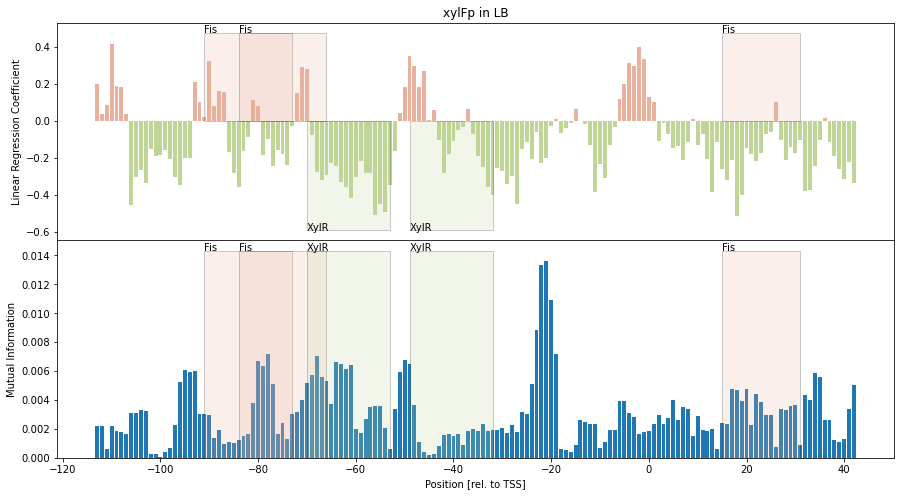

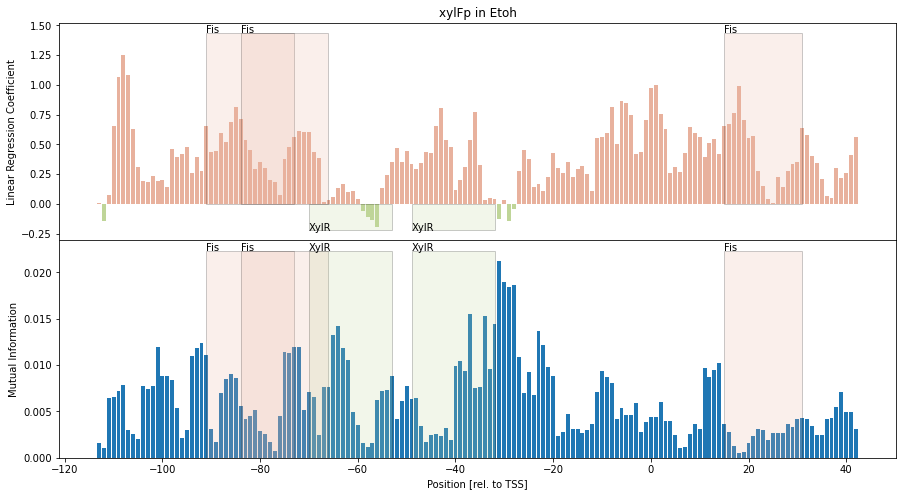

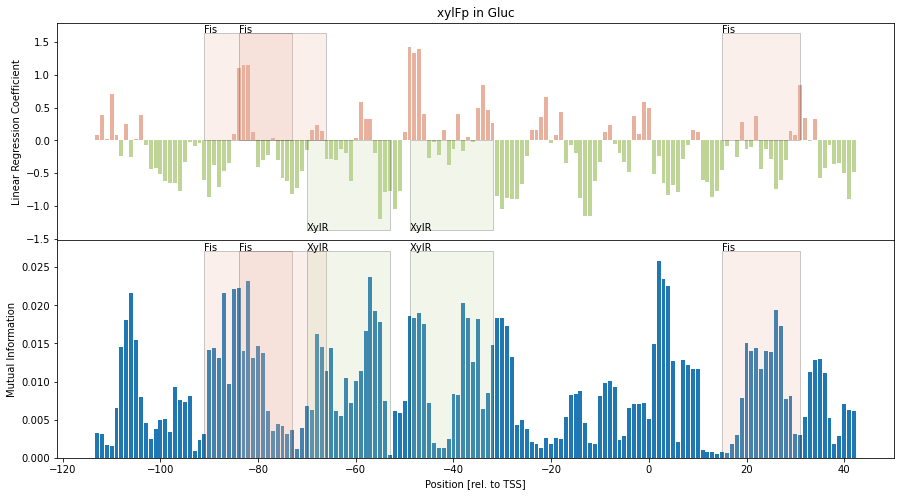

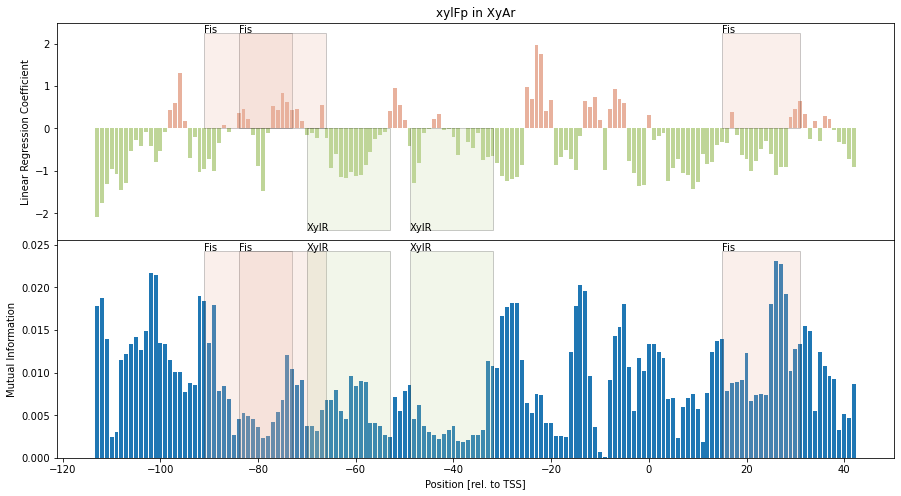

In [164]:
promoter = "xylFp"

sites = [
    (-91, -73, "rep", "Fis"),
    (-84, -66, "rep", "Fis"),
    (-70, -53, "act", "XylR"),
    (-49, -32, "act", "XylR"),
    (15, 31, "rep", "Fis"),
]

make_footprints(promoter, sites)

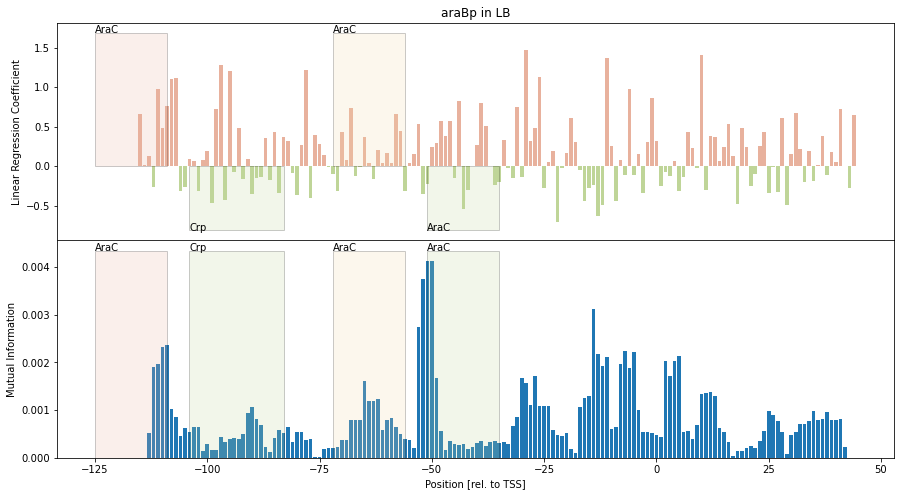

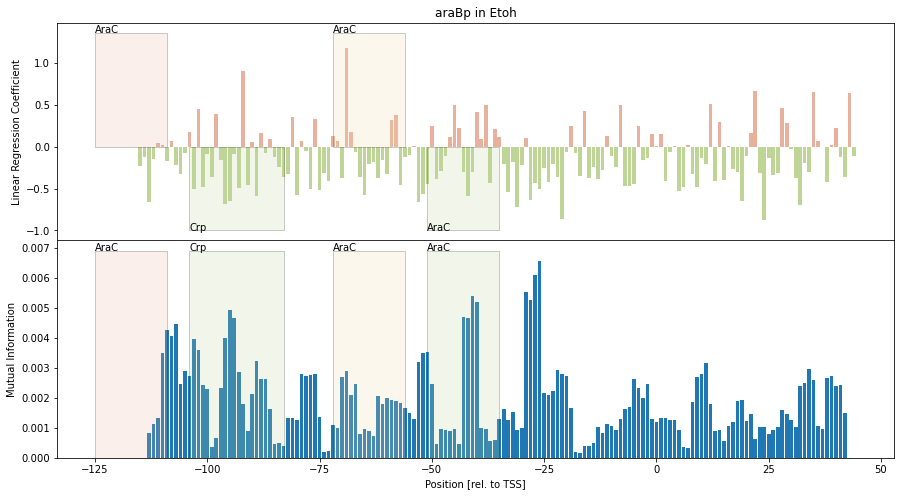

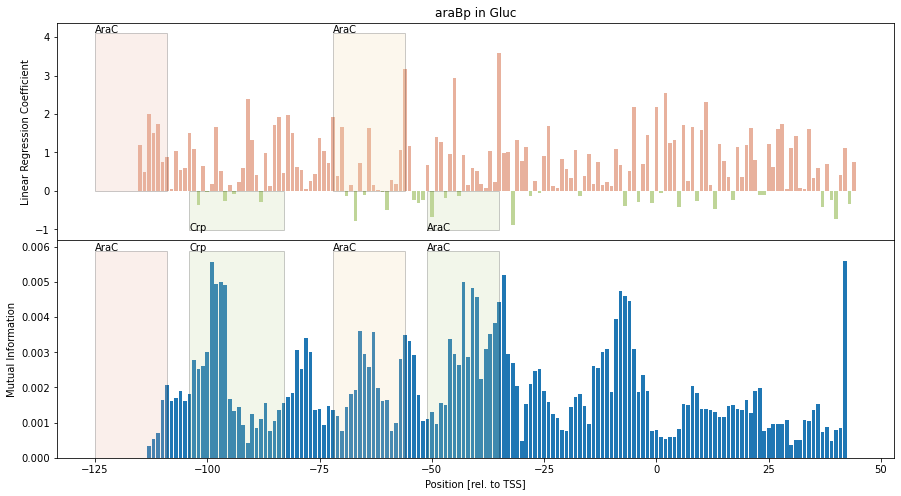

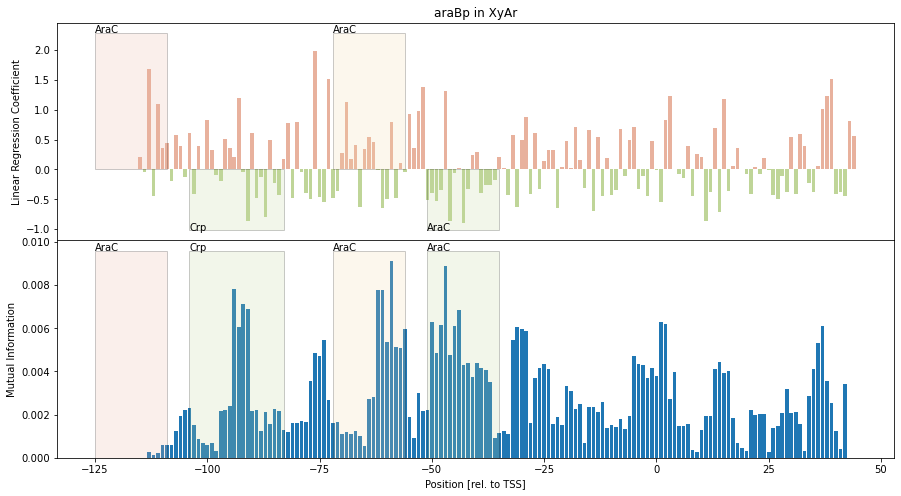

In [148]:
promoter = "araBp"

sites = [
    (-125, -109, "rep", "AraC"),
    (-104, -83, "act", "Crp"),
    (-72, -56, "dual", "AraC"),
    (-51, -35, "act", "AraC"),
]

make_footprints(promoter, sites)

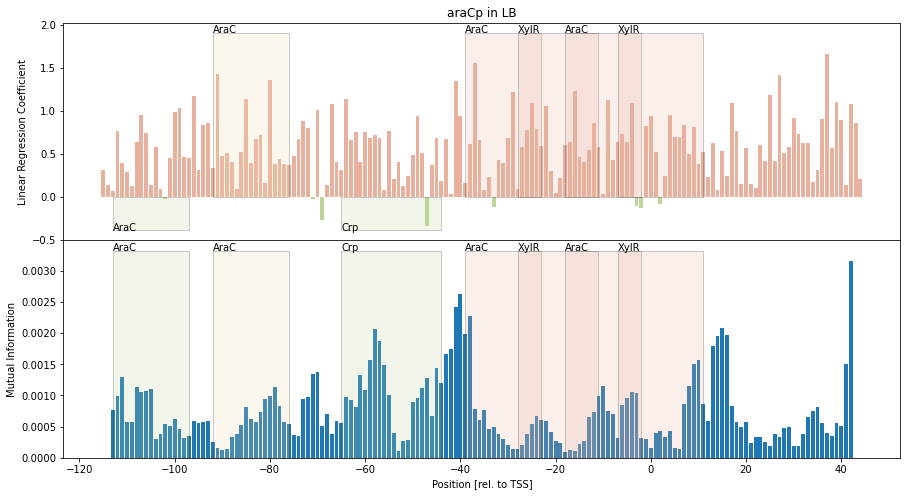

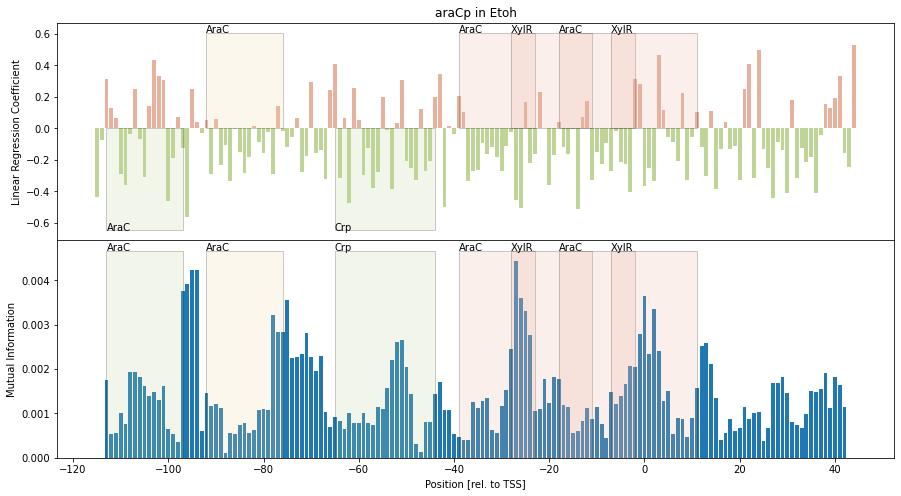

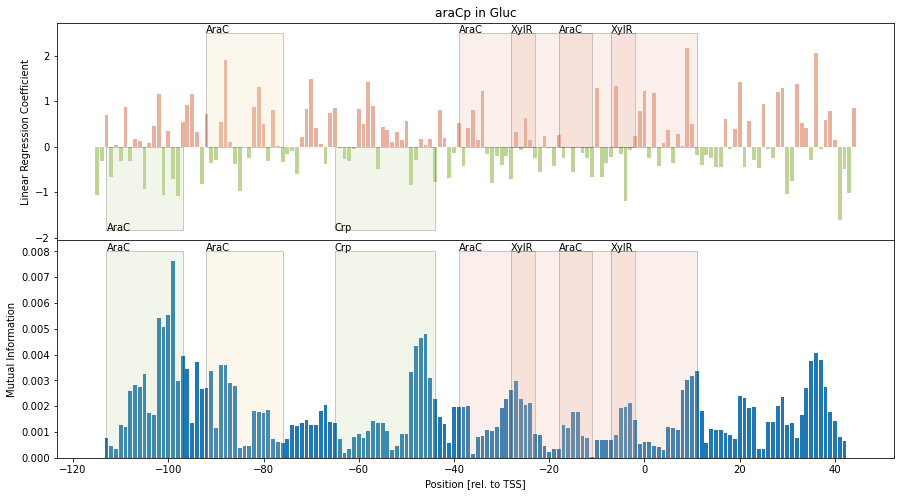

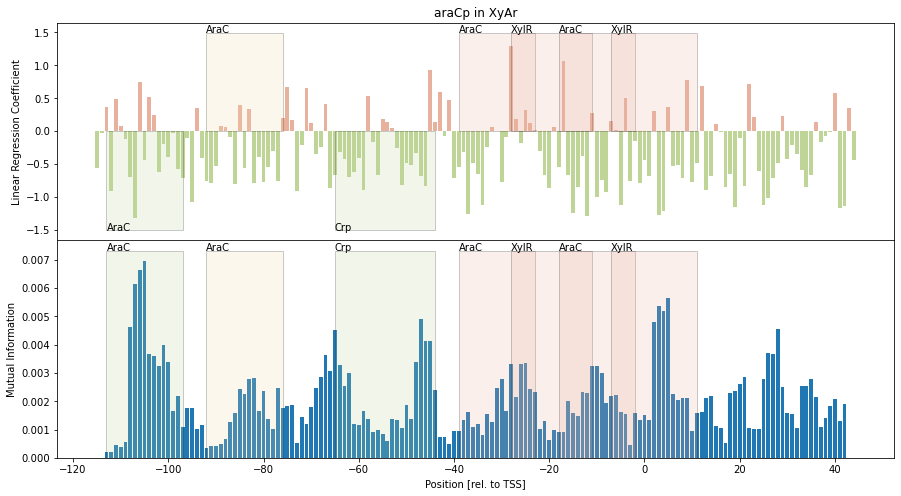

In [149]:
promoter = "araCp"

sites = [
    (-113, -97, "act", "AraC"),
    (-92, -76, "dual", "AraC"),
    (-65, -44, "act", "Crp"),
    (-39, -23, "rep", "AraC"),
    (-28, -11, "rep", "XylR"),
    (-18, -2, "rep", "AraC"),
    (-7, 11, "rep", "XylR"),
]

make_footprints(promoter, sites)

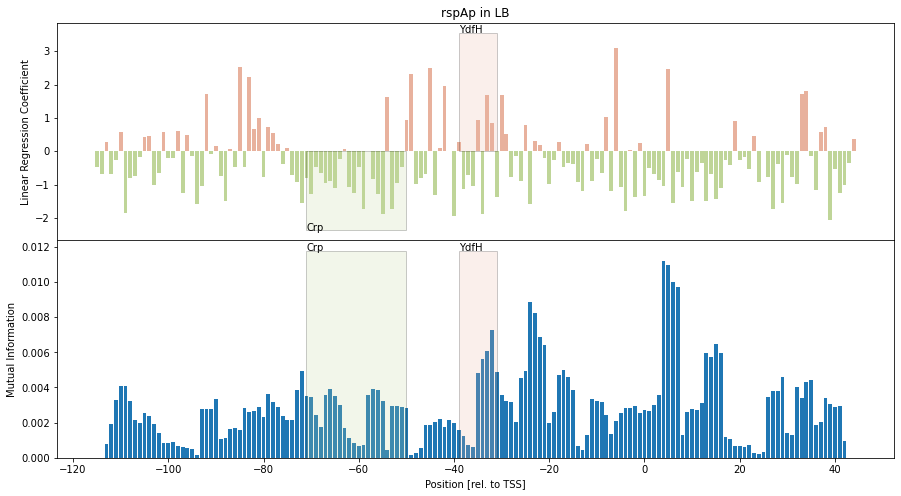

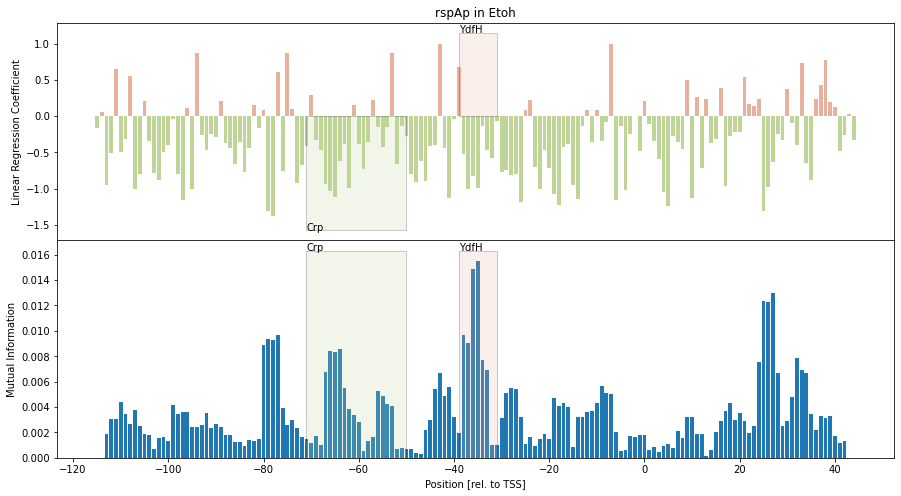

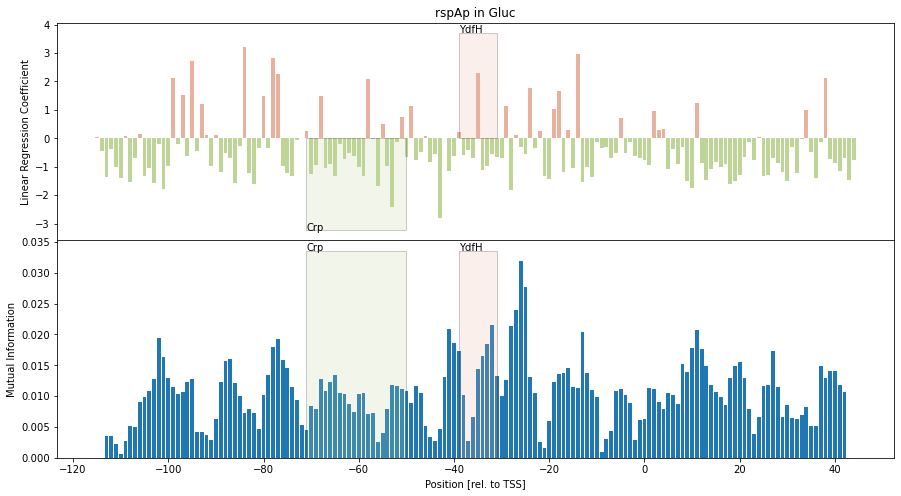

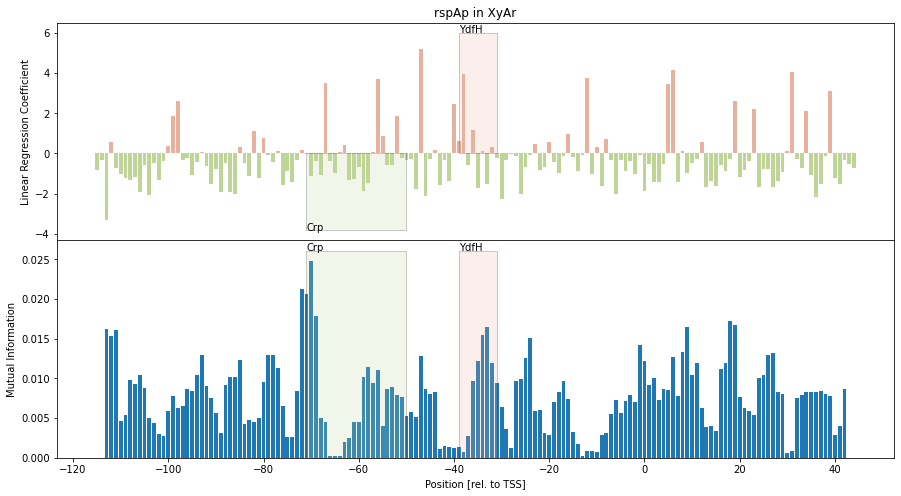

In [150]:
promoter = "rspAp"

sites = [
    (-39, -31, "rep", "YdfH"),
    (-71, -50, "act", "Crp"),
]
make_footprints(promoter, sites)

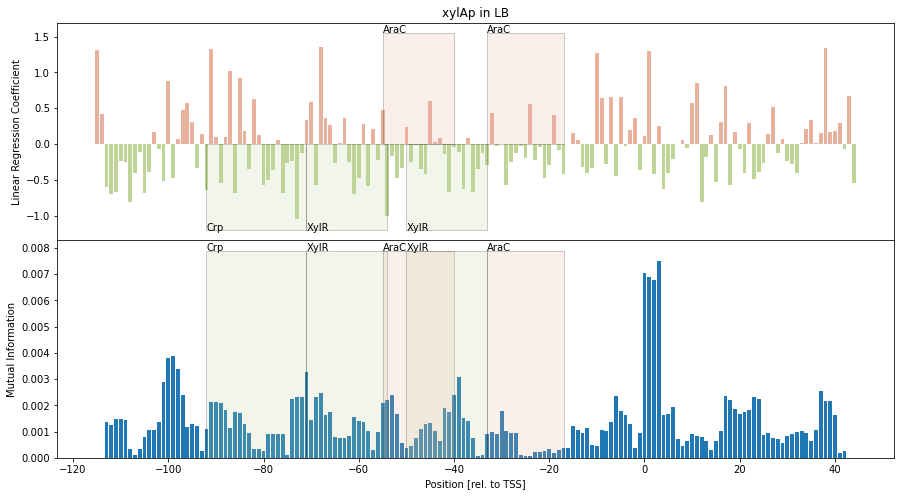

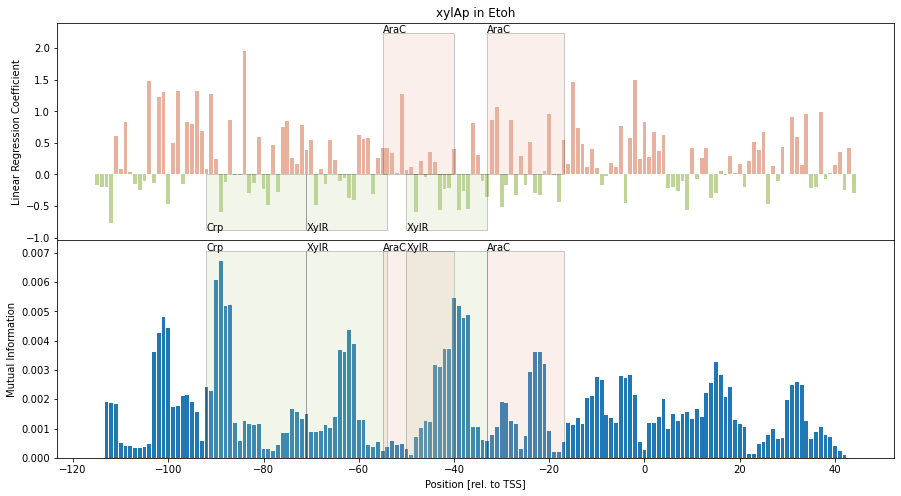

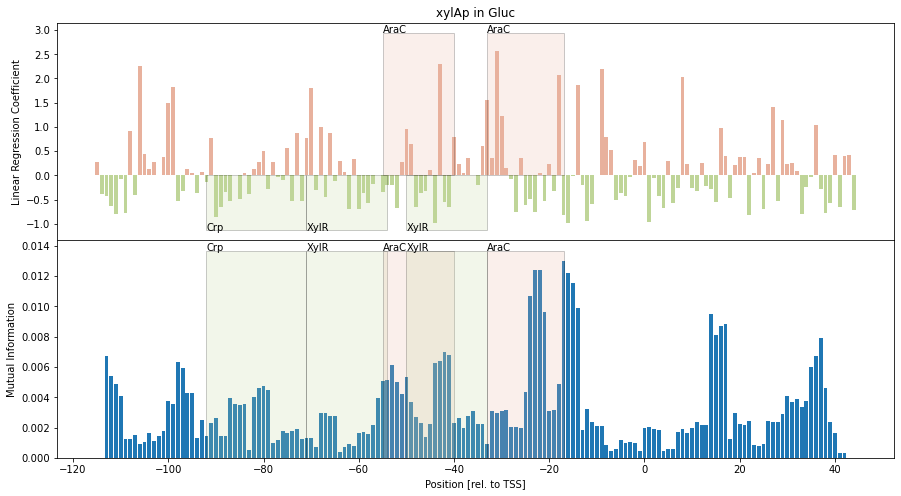

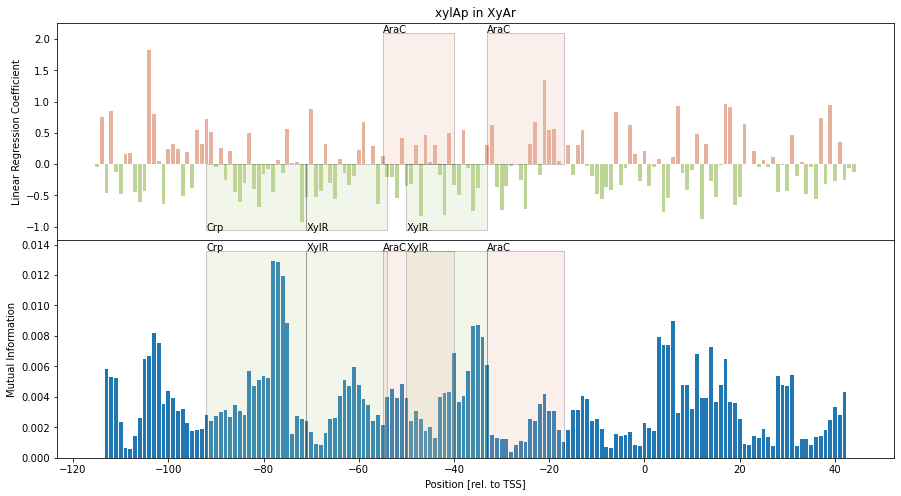

In [151]:
promoter = "xylAp"

sites = [
    (-92, -71, "act", "Crp"),
    (-71, -54, "act", "XylR"),
    (-55, -40, "rep", "AraC"),
    (-50, -33, "act", "XylR"),
    (-33, -17, "rep", "AraC"),
]

make_footprints(promoter, sites)

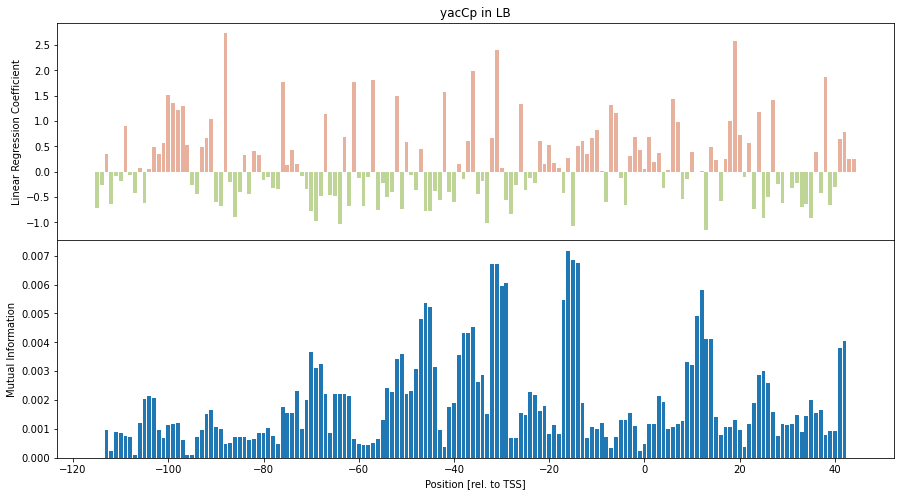

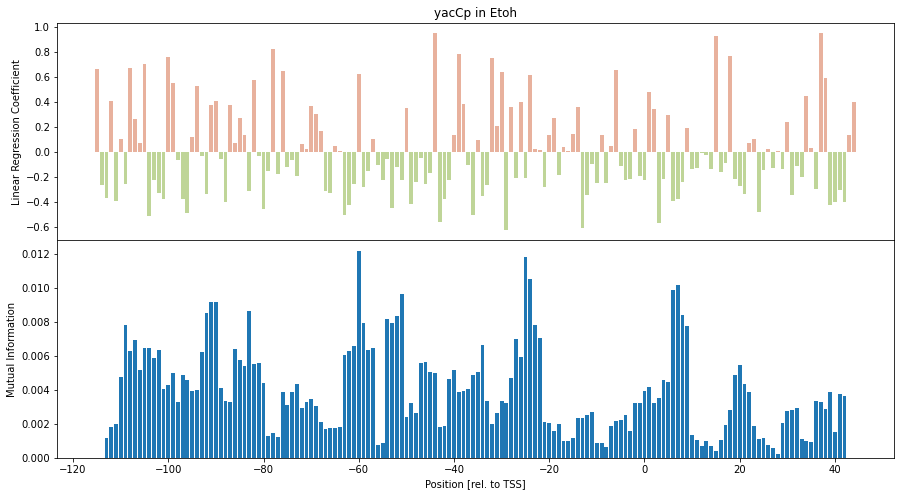

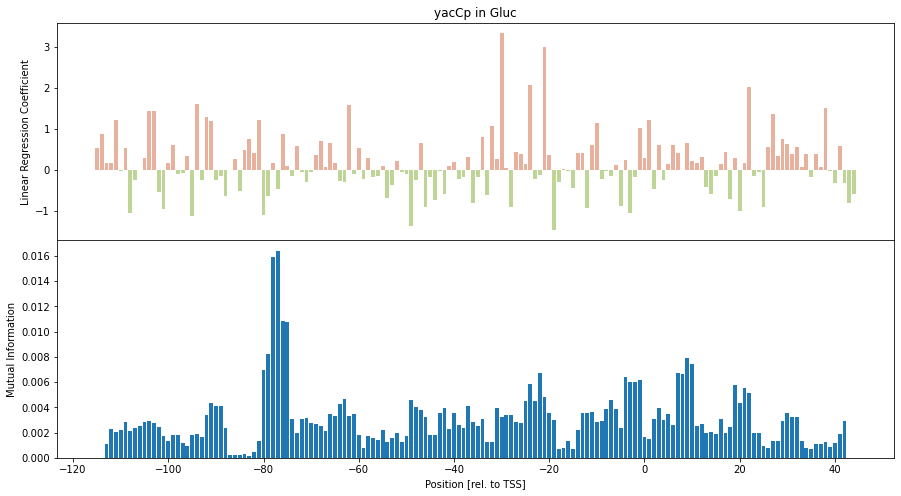

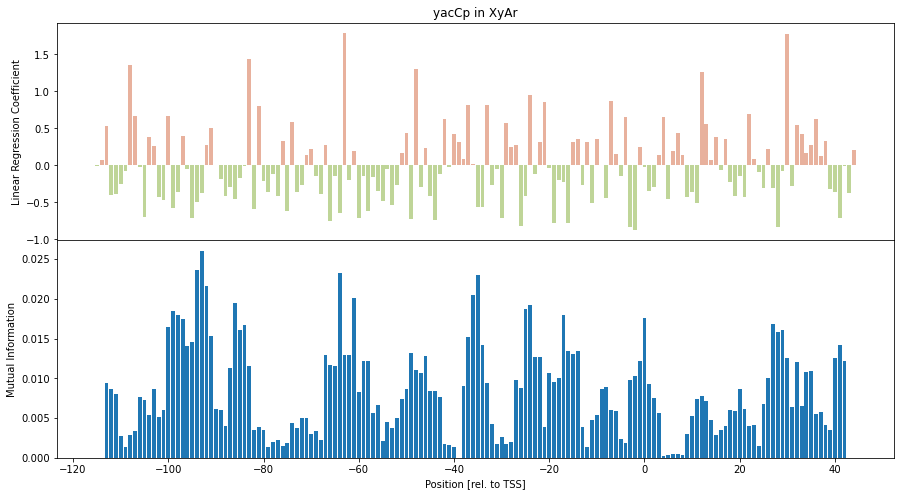

In [152]:
promoter = "yacCp"

sites = [
]
make_footprints(promoter, sites)

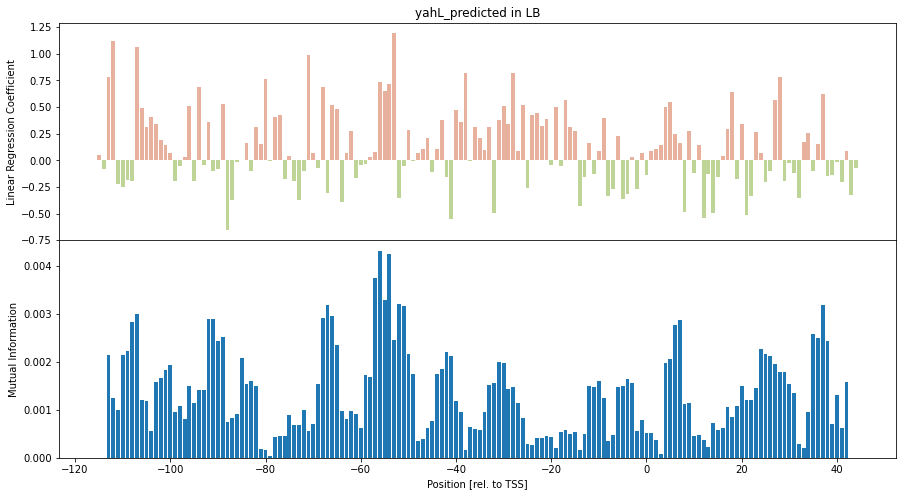

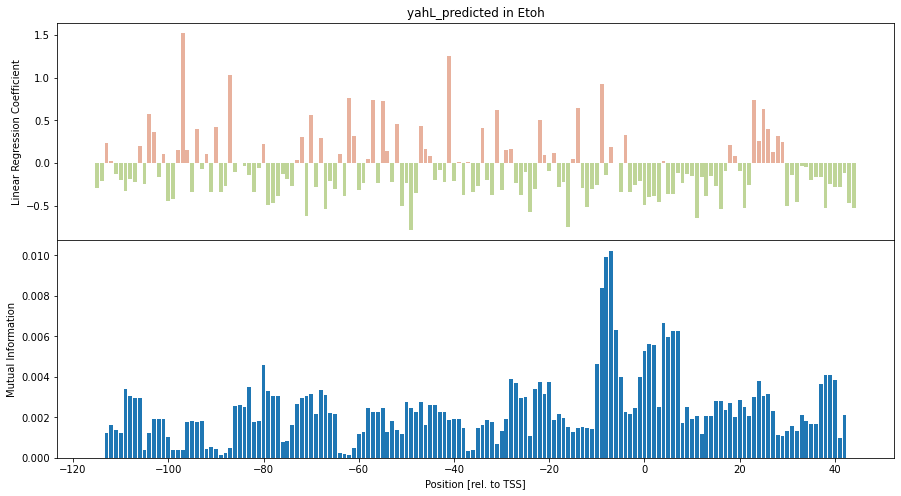

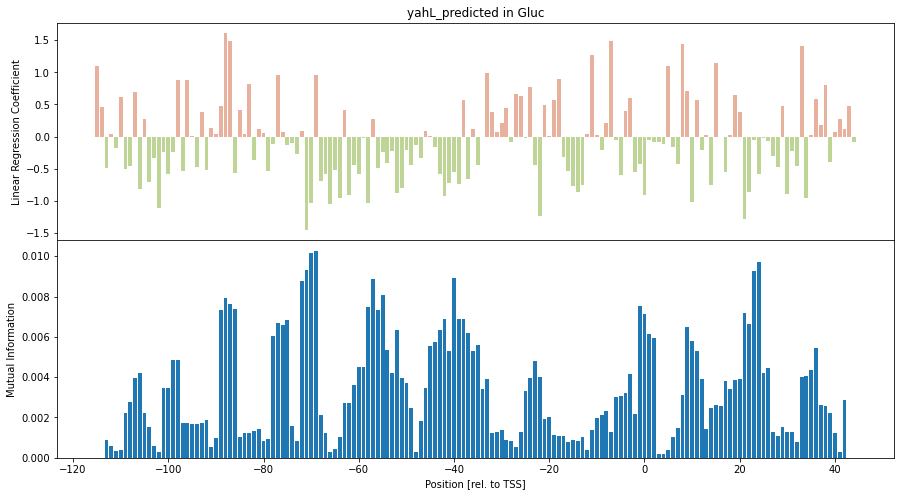

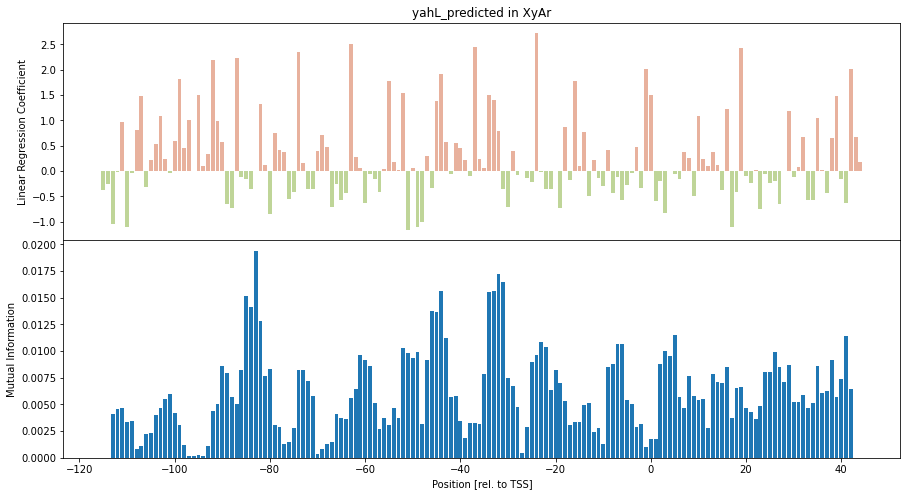

In [153]:
promoter = find_promoter("yahL")
sites = [
]
make_footprints(promoter, sites)

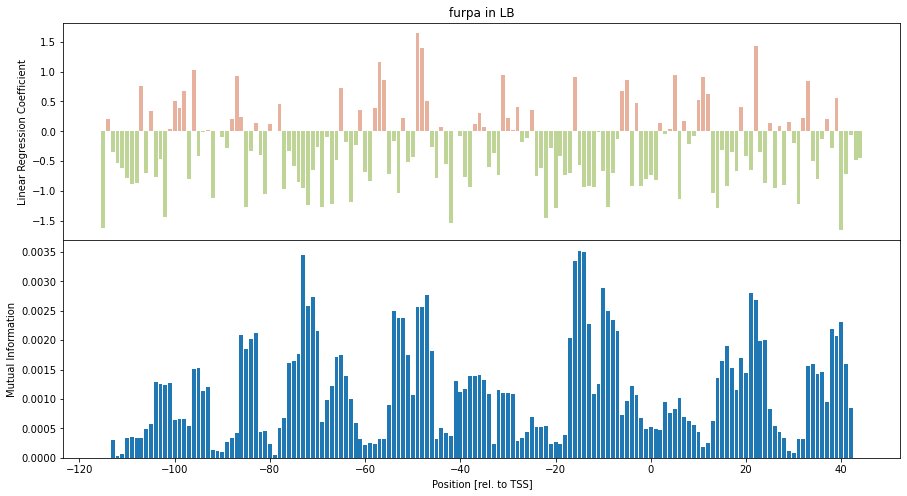

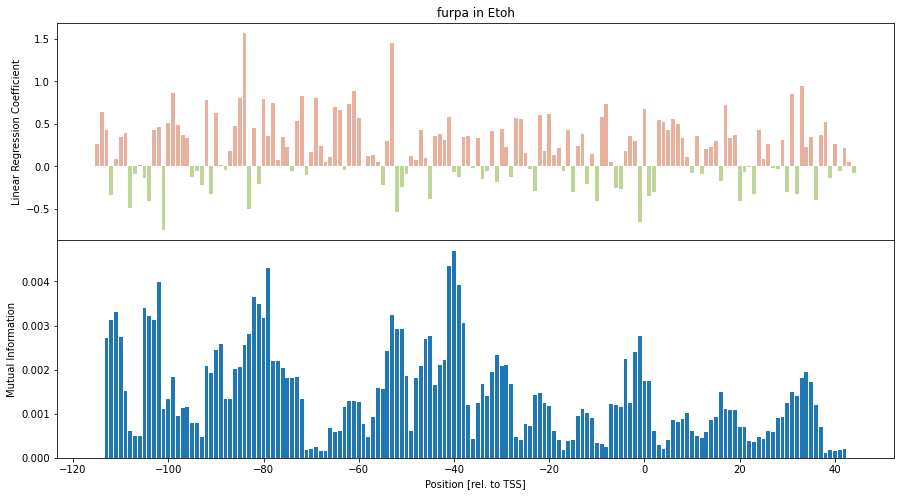

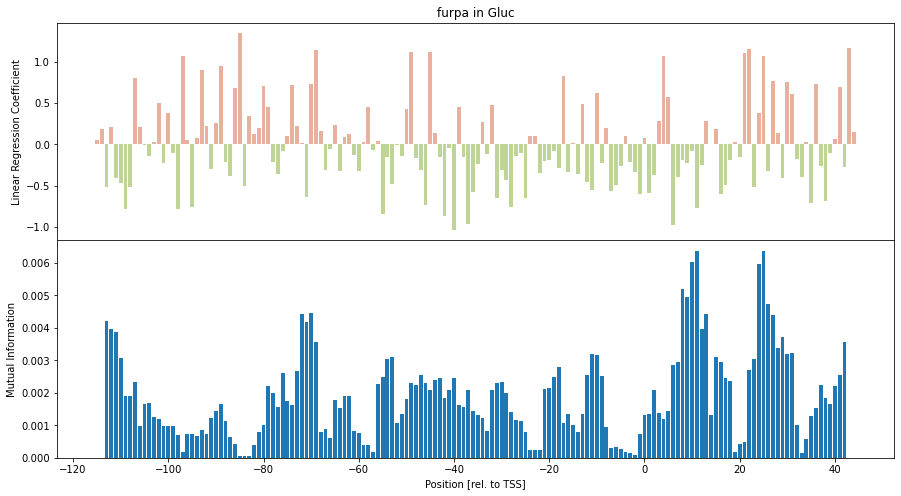

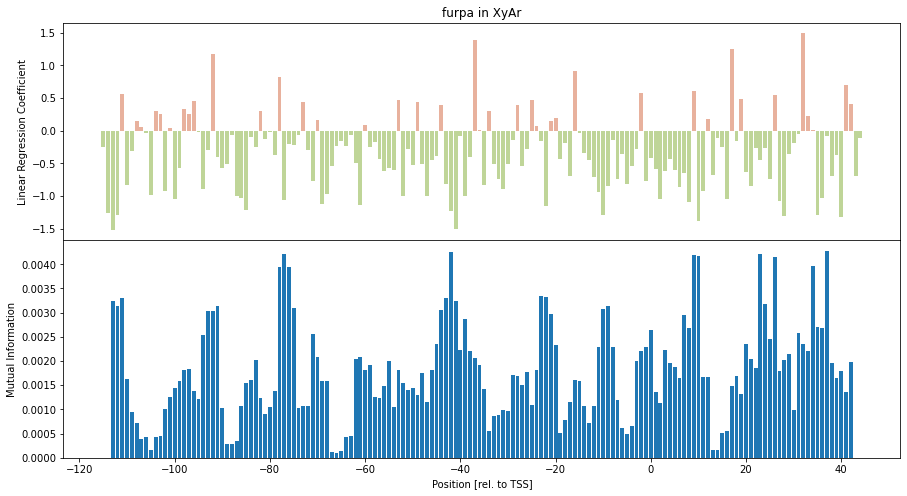

In [154]:
promoter = find_promoter("fur")
sites = [
]
make_footprints(promoter, sites)

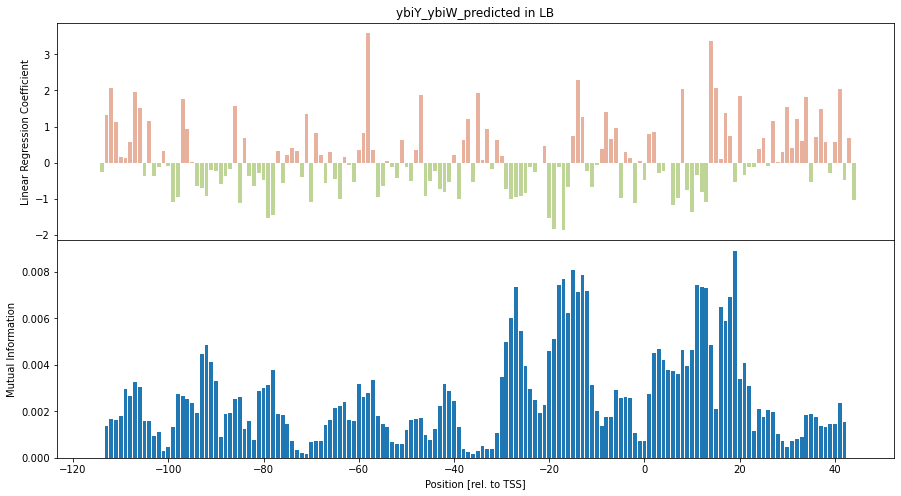

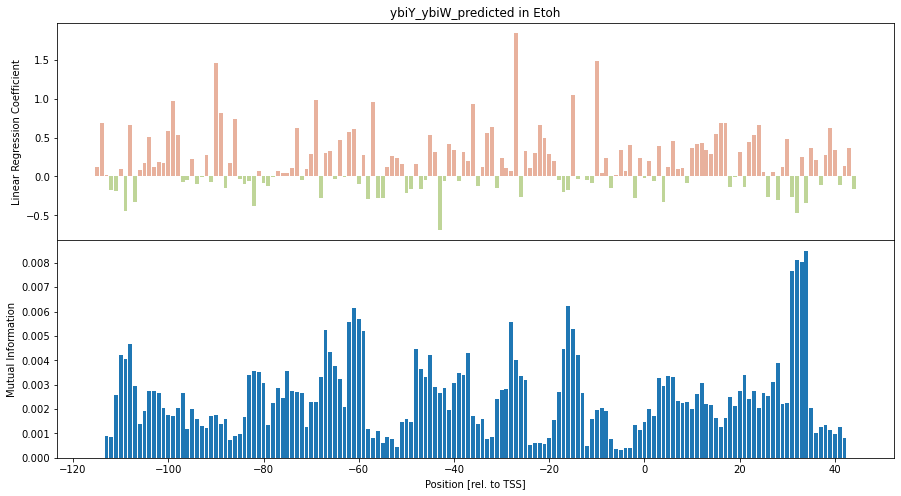

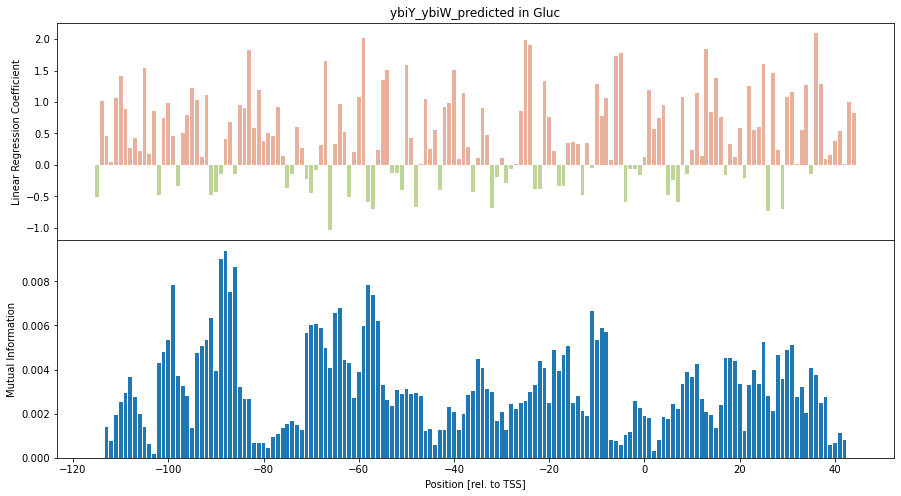

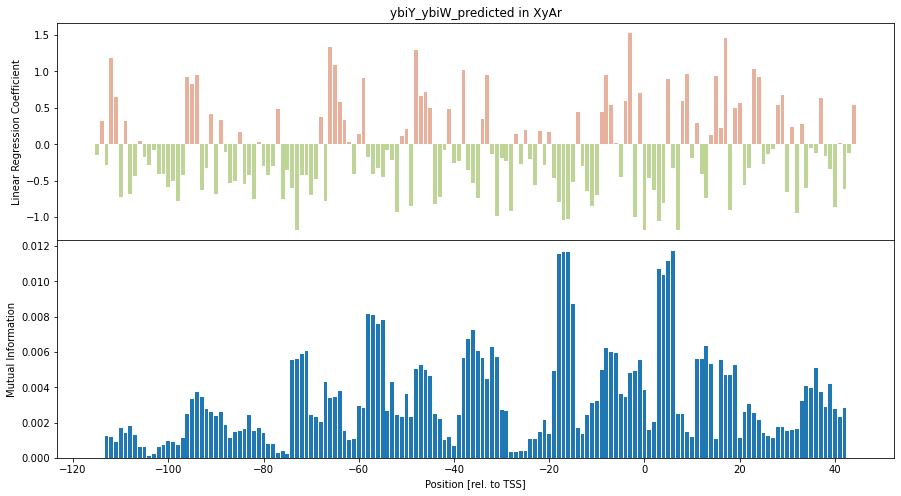

In [155]:
promoter = find_promoter("ybiY")
sites = [
]
make_footprints(promoter, sites)

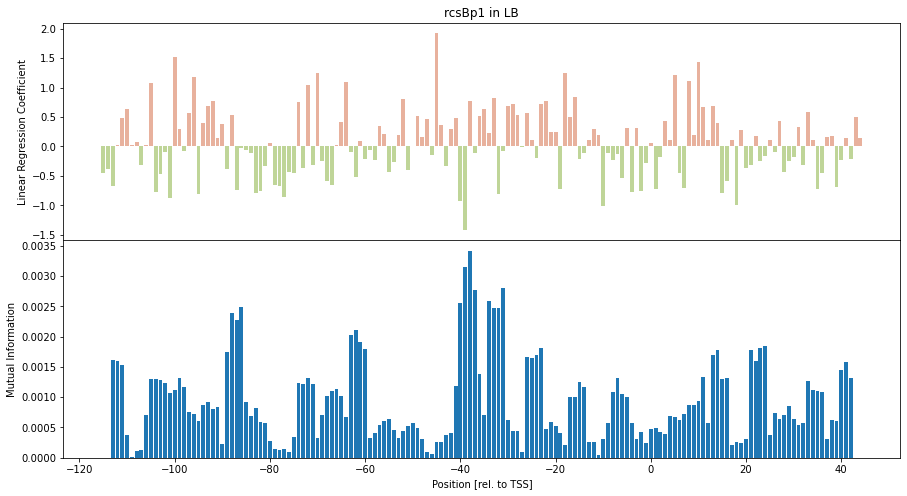

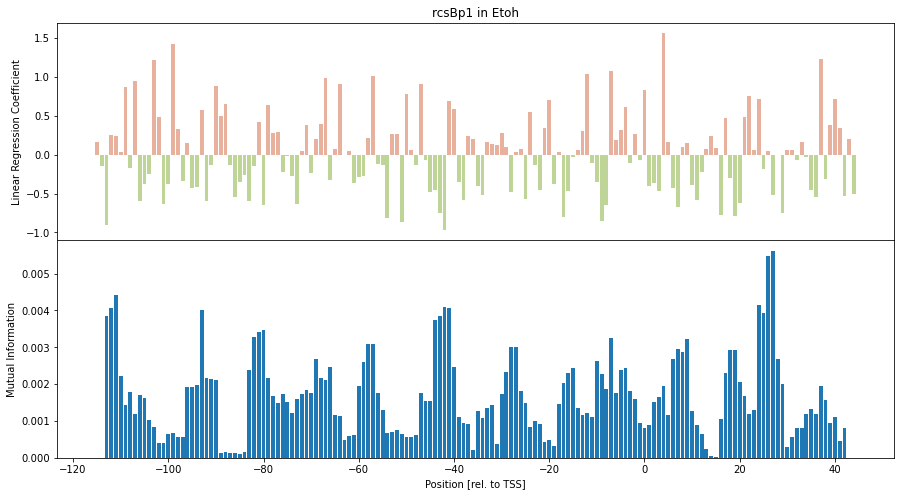

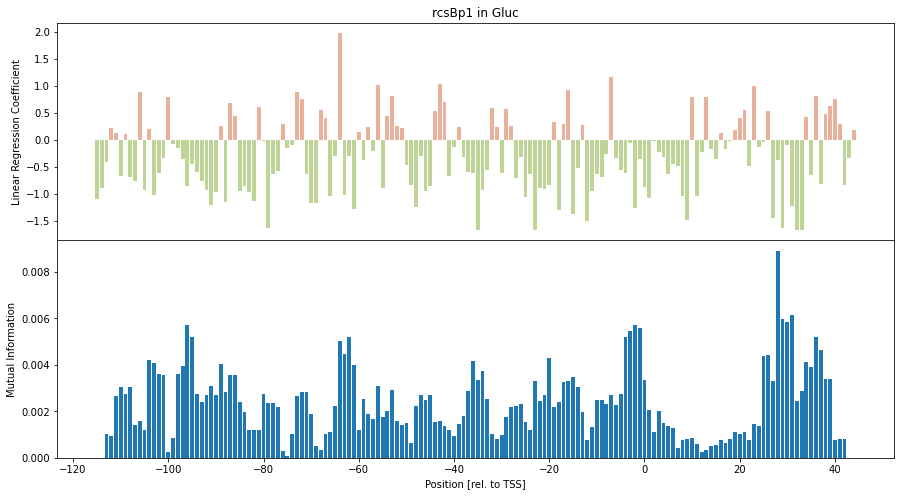

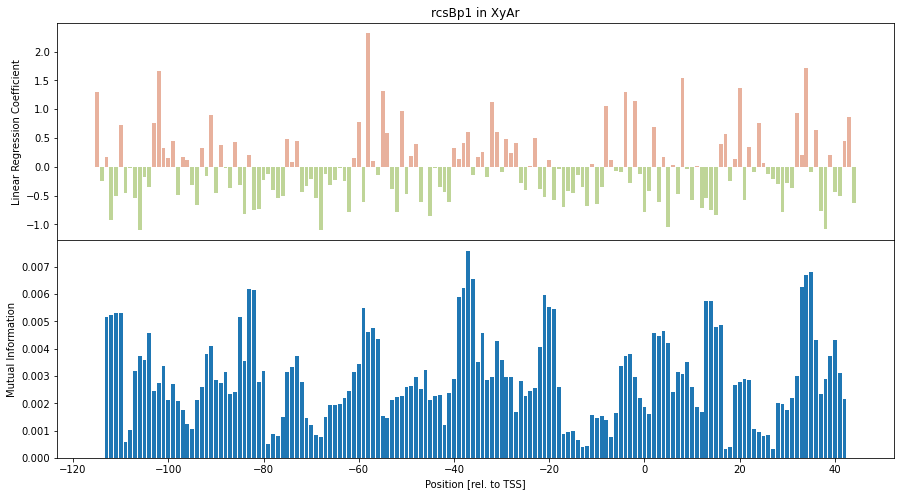

In [156]:
promoter = find_promoter("rcsB")
sites = [
]
make_footprints(promoter, sites)

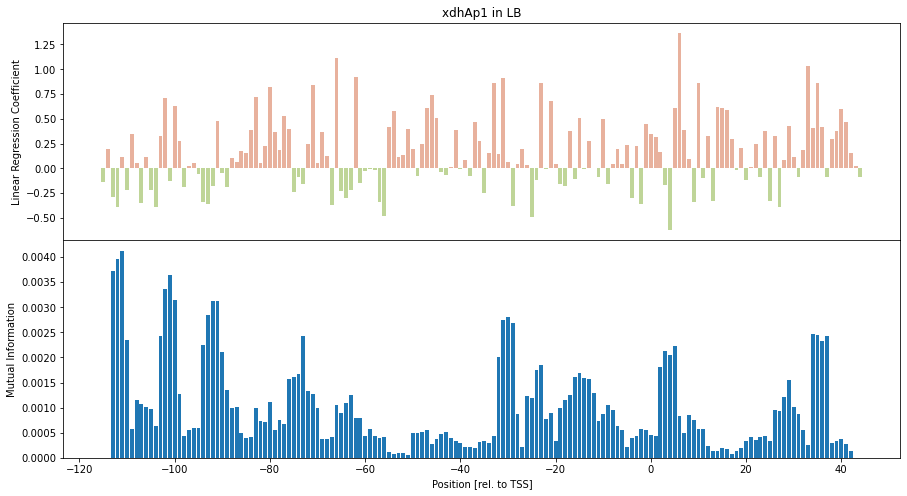

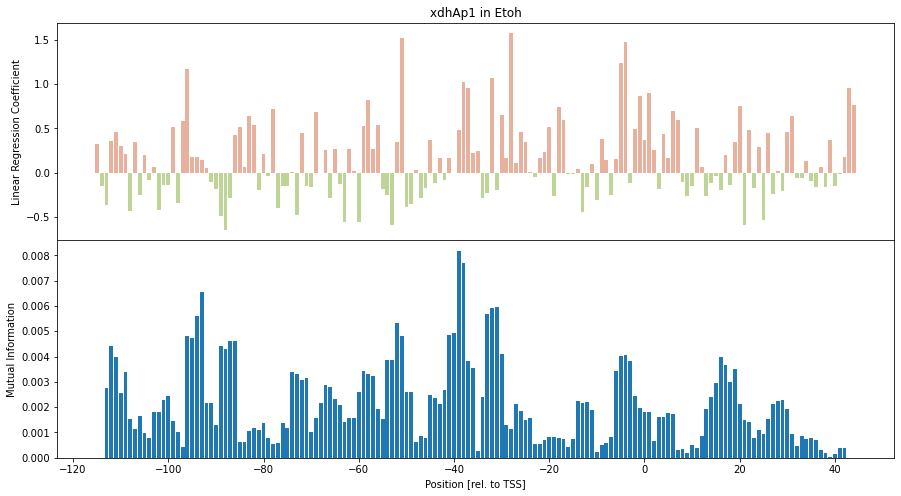

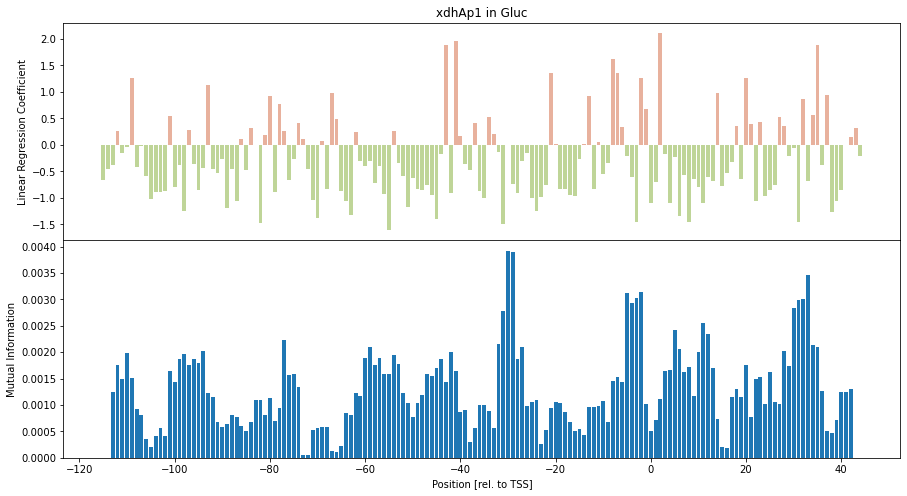

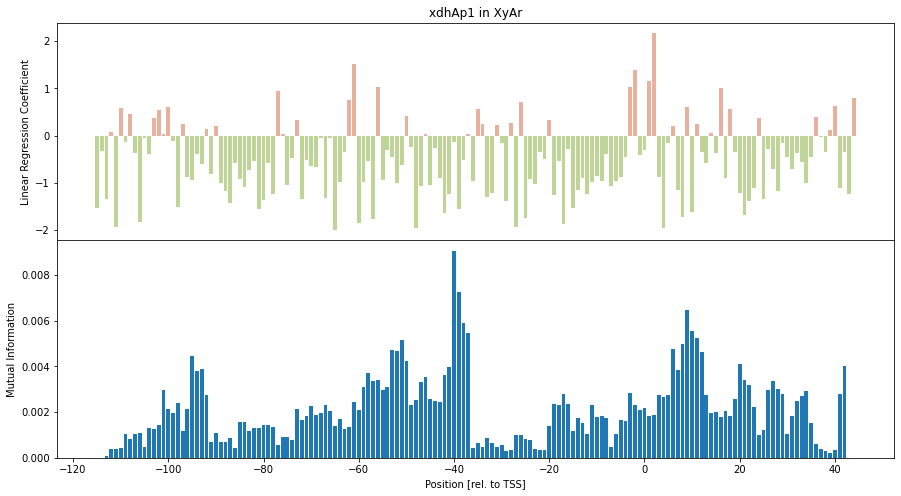

In [157]:
promoter = find_promoter("xdhA")
sites = [
]
make_footprints(promoter, sites)

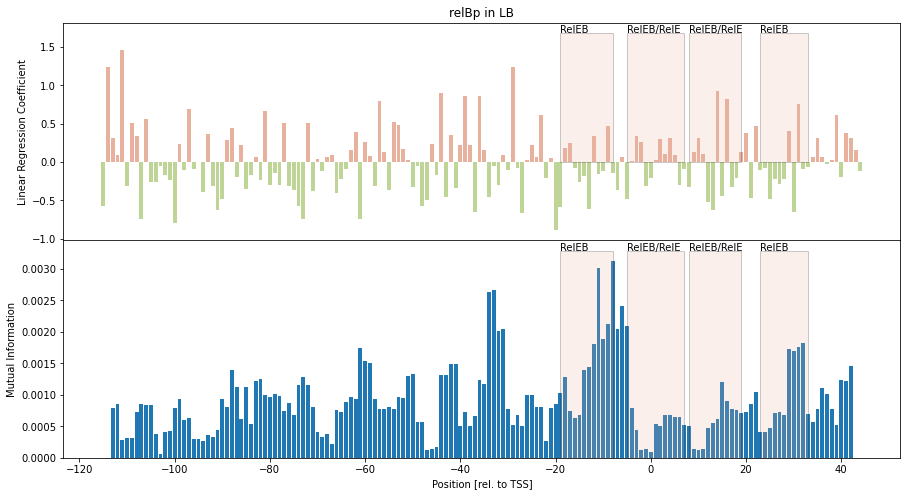

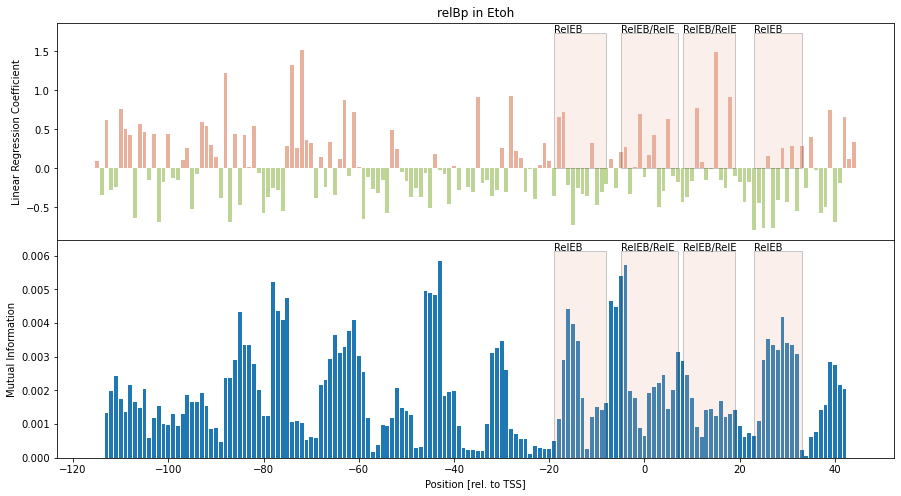

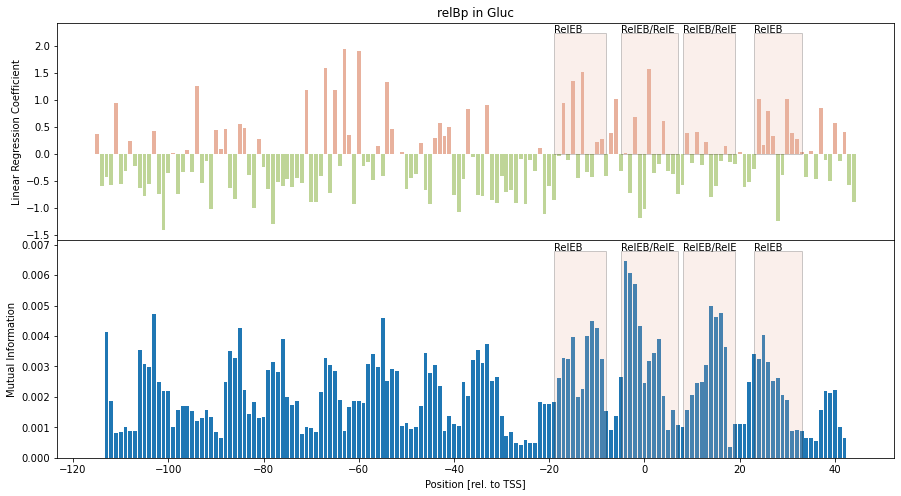

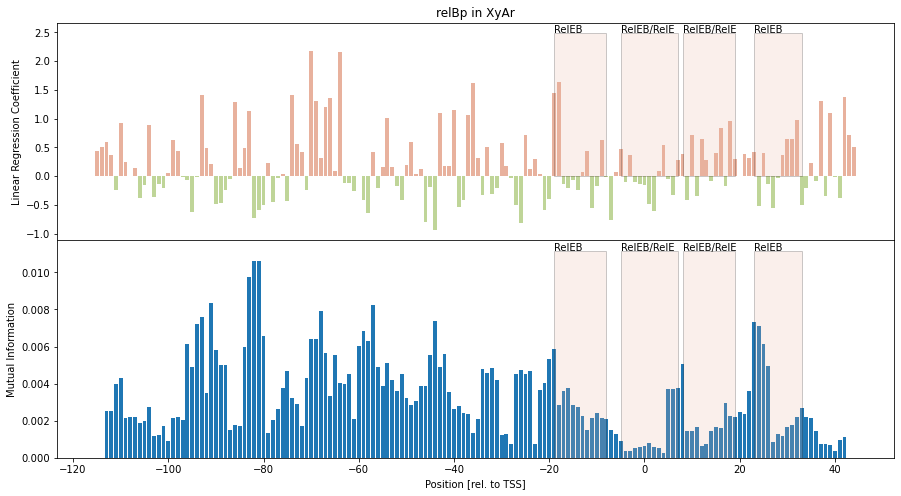

In [158]:
promoter = find_promoter("relB")
sites = [
    (-19, -8, "rep", "RelEB"),
    (-5, 7, "rep", "RelEB/RelE"),
    (8, 19, "rep", "RelEB/RelE"),
    (23, 33, "rep", "RelEB")
]
make_footprints(promoter, sites)

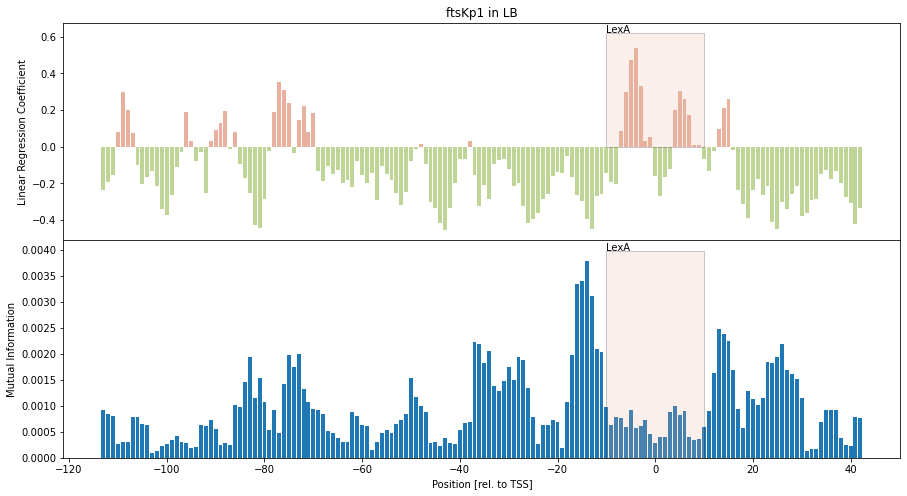

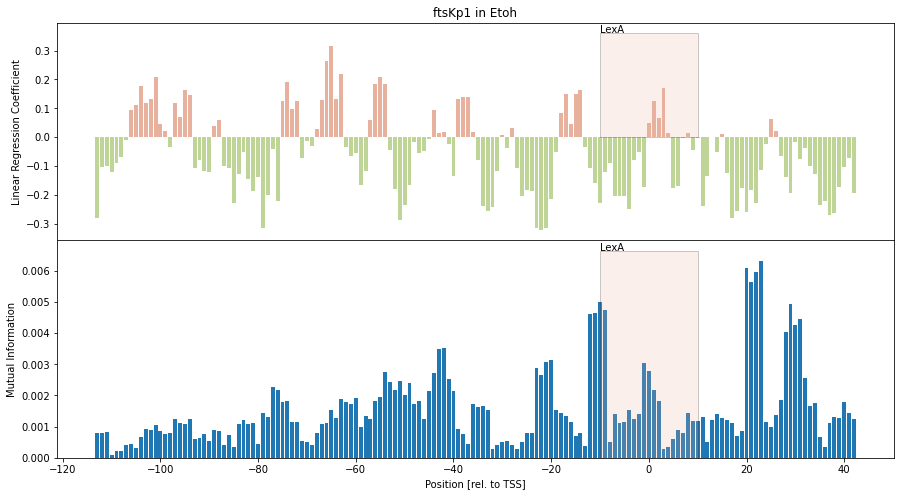

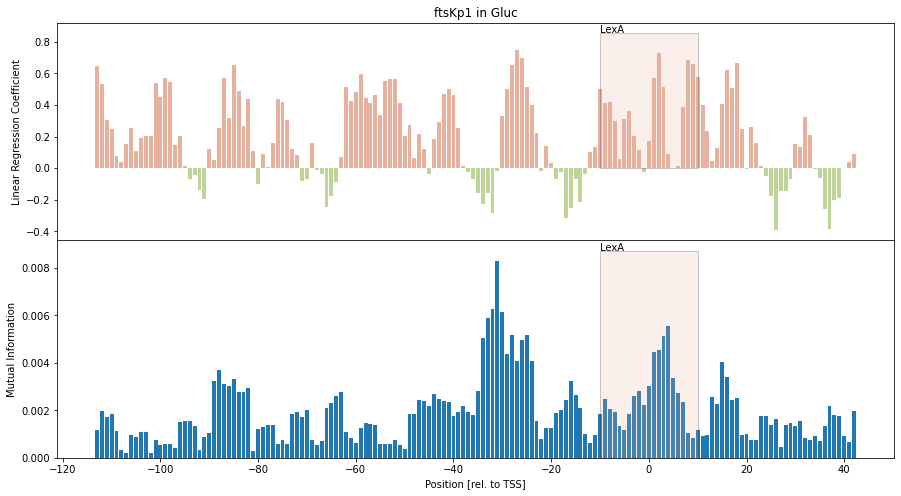

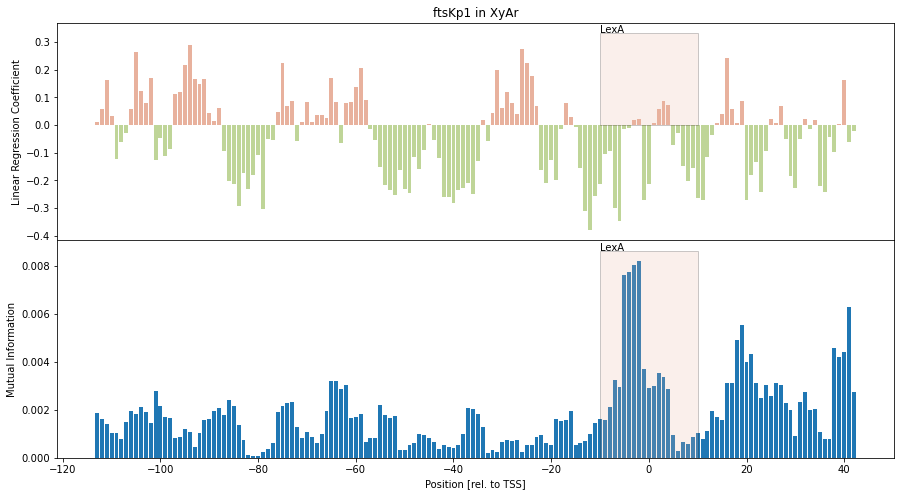

In [165]:
promoter = find_promoter("ftsK")
sites = [
    (-10, 10, "rep", "LexA"),
]
make_footprints(promoter, sites)

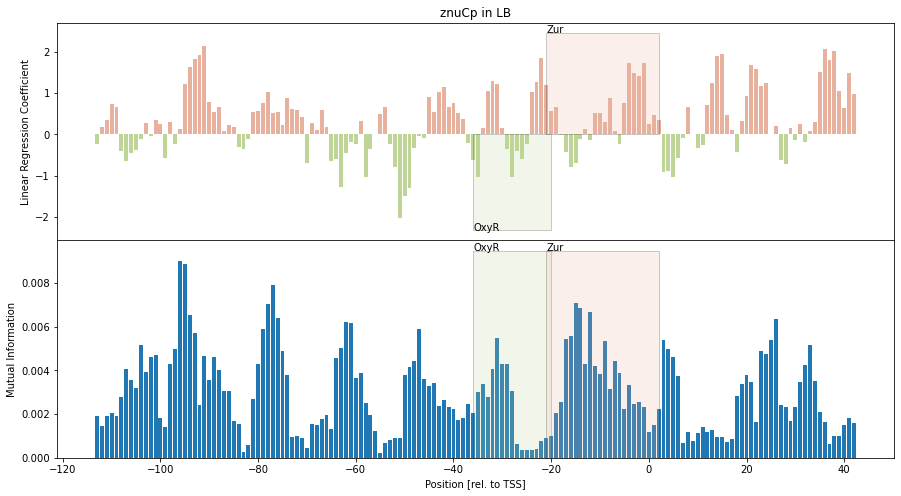

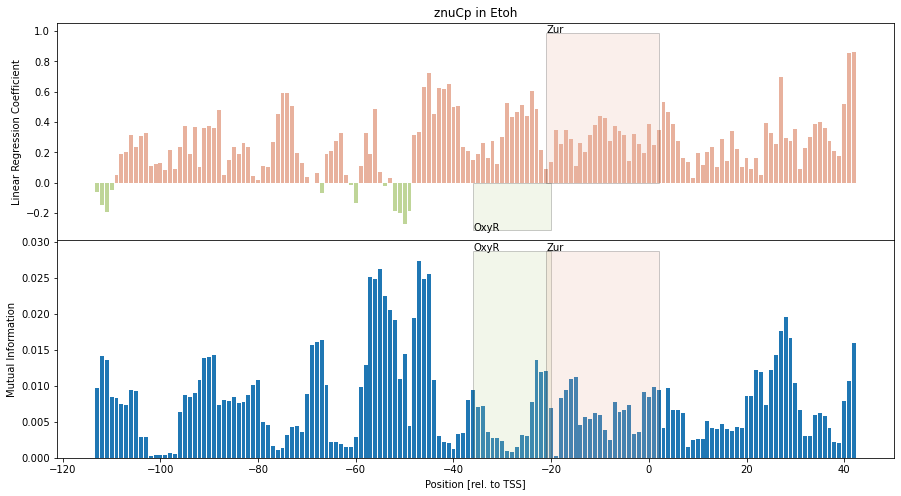

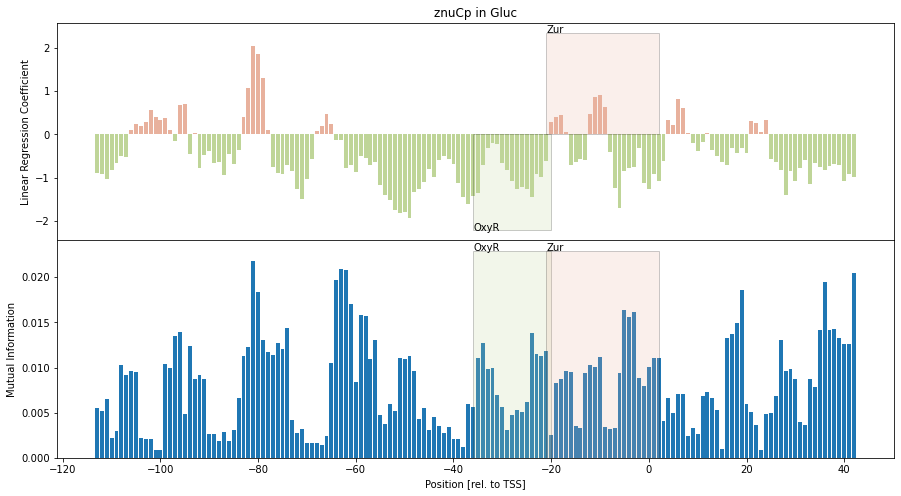

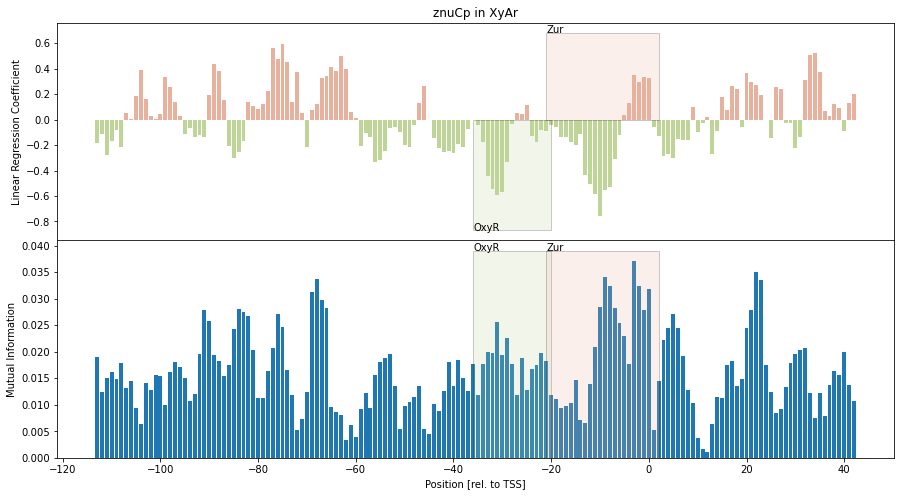

In [169]:
promoter = find_promoter("znuC")
sites = [
    (-36, -20, "act", "OxyR"),
    (-21, 2, "rep", "Zur")
]
make_footprints(promoter, sites)

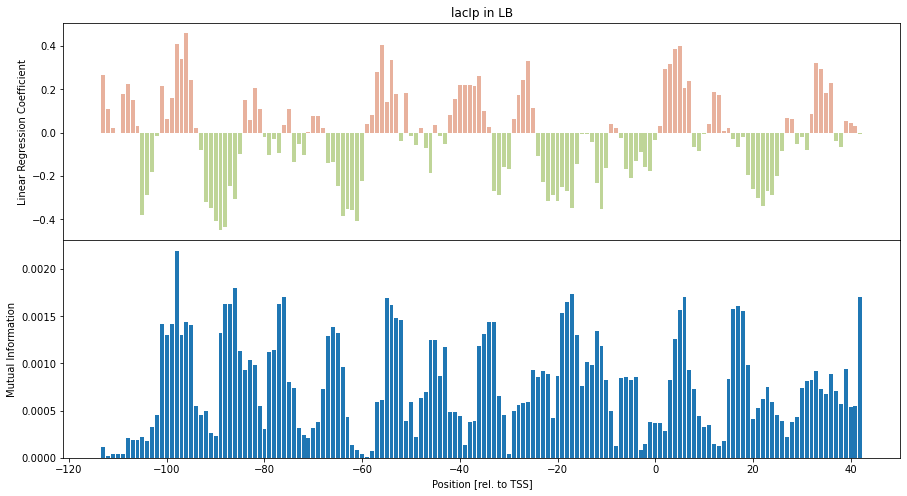

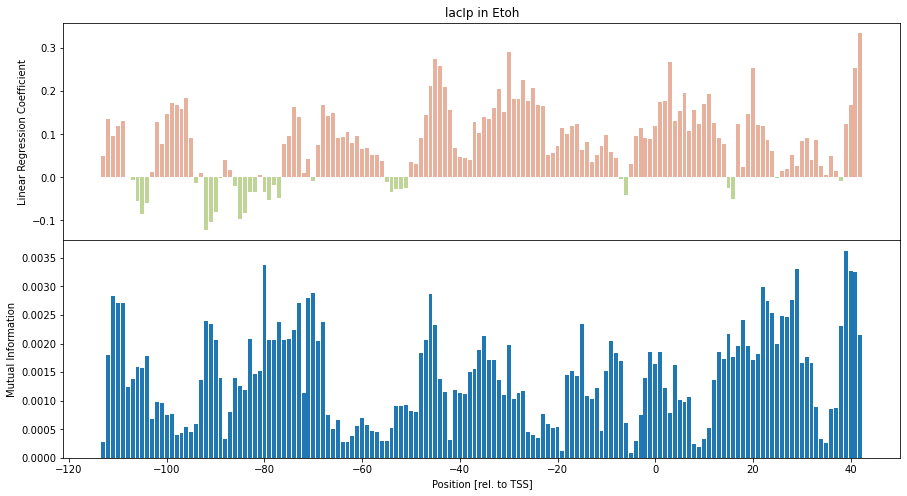

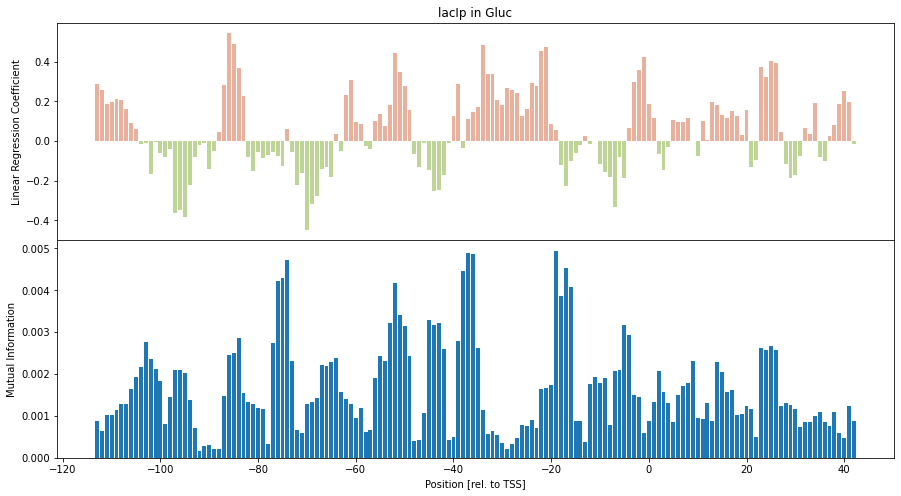

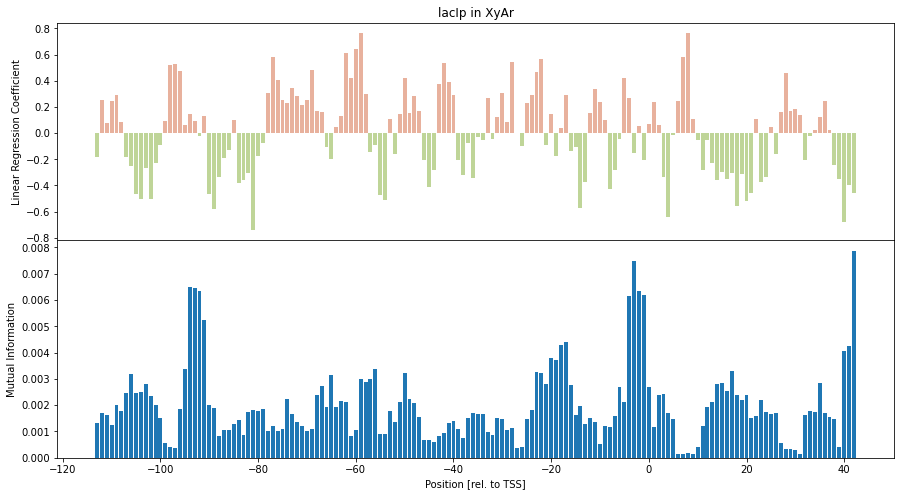

In [170]:

promoter = find_promoter("lacI")
sites = [
]
make_footprints(promoter, sites)

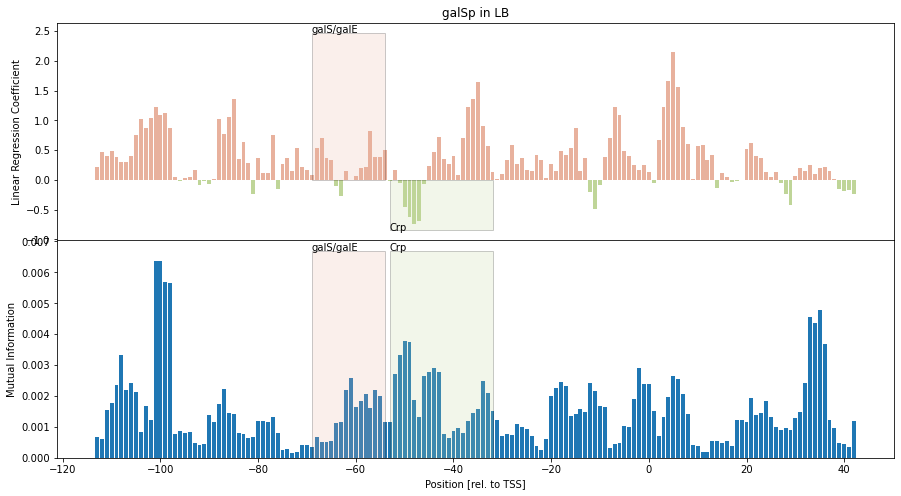

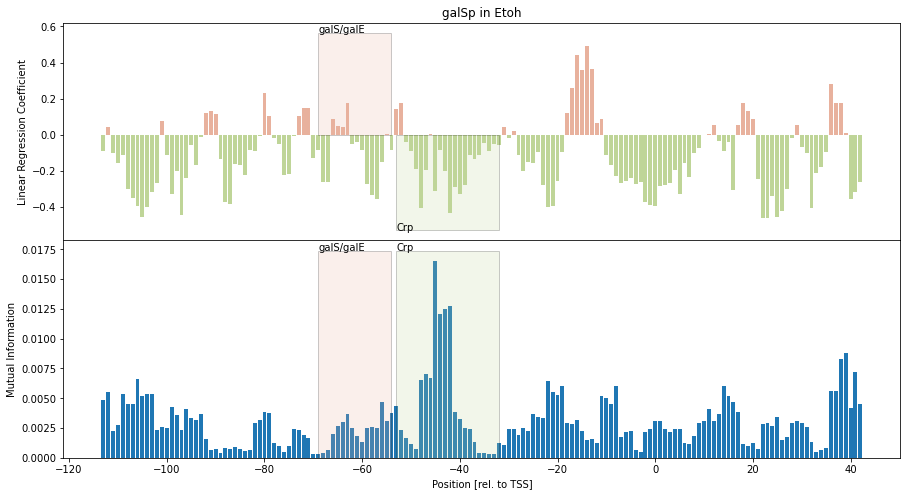

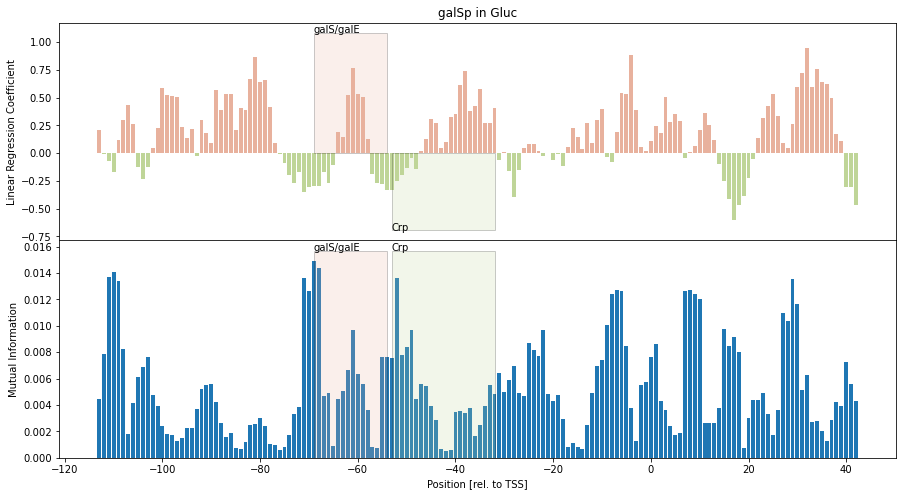

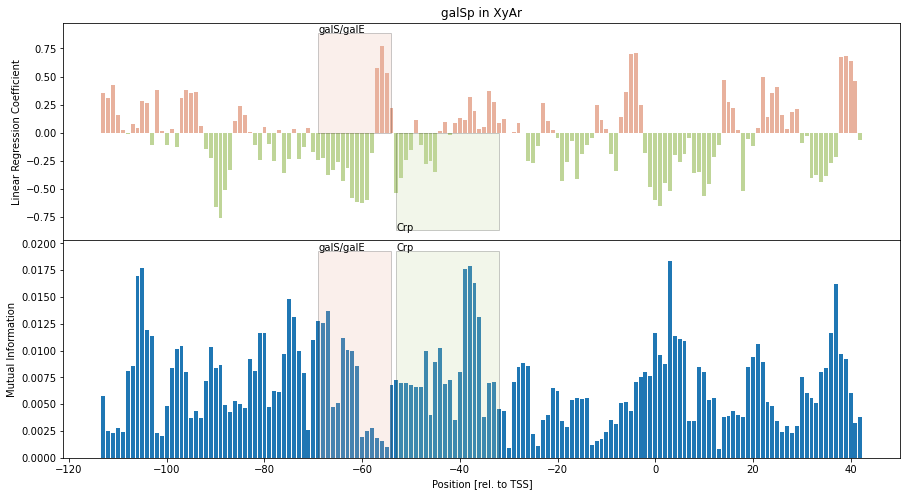

In [171]:
promoter = find_promoter("galS")
sites = [
    (-69, -54, "rep", "galS/galE"),
    (-53, -32, "act", "Crp")
]
make_footprints(promoter, sites)

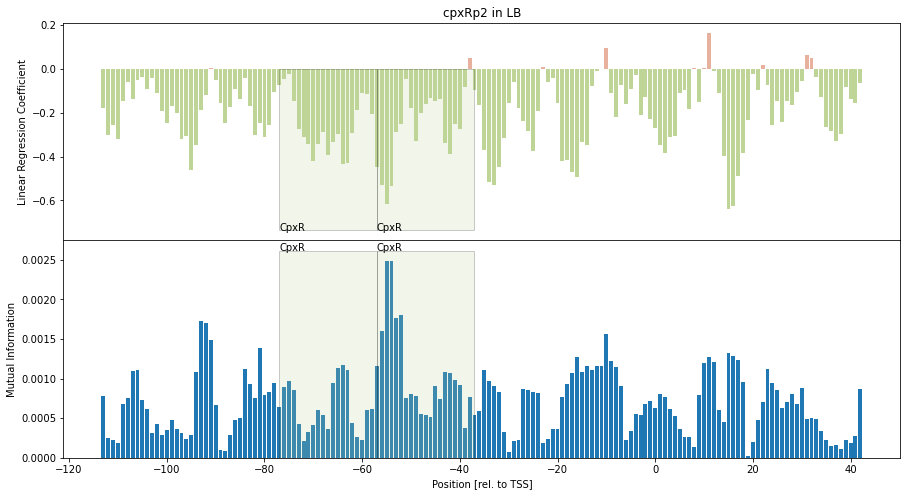

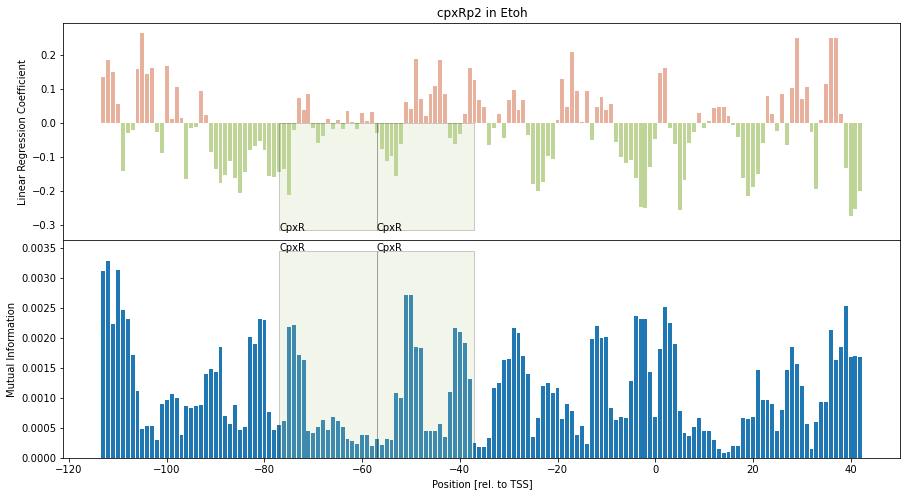

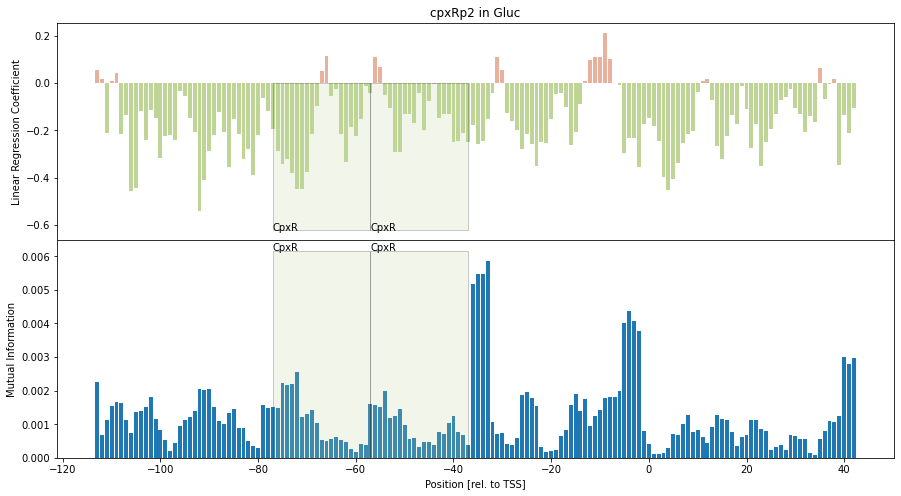

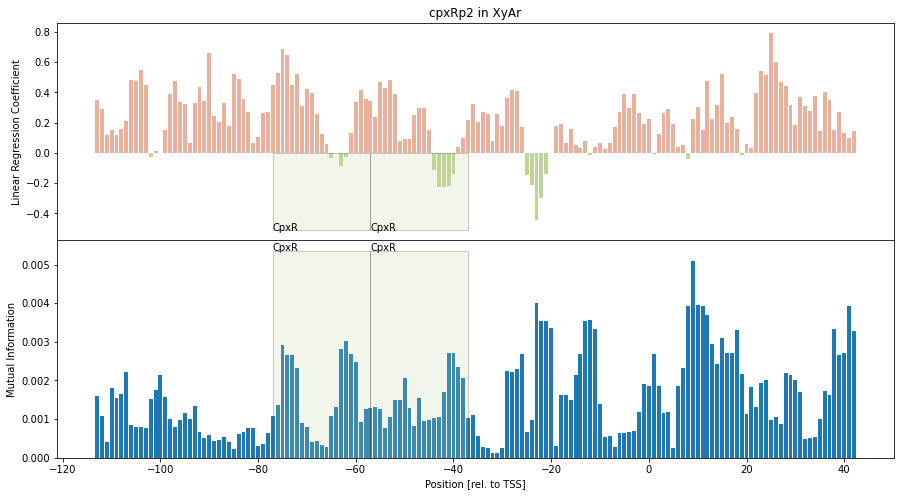

In [177]:
promoter = find_promoter("cpxR")
sites = [
    (-57, -37, "act", "CpxR"),
    (-77, -57, "act", "CpxR")
]
make_footprints(promoter, sites)

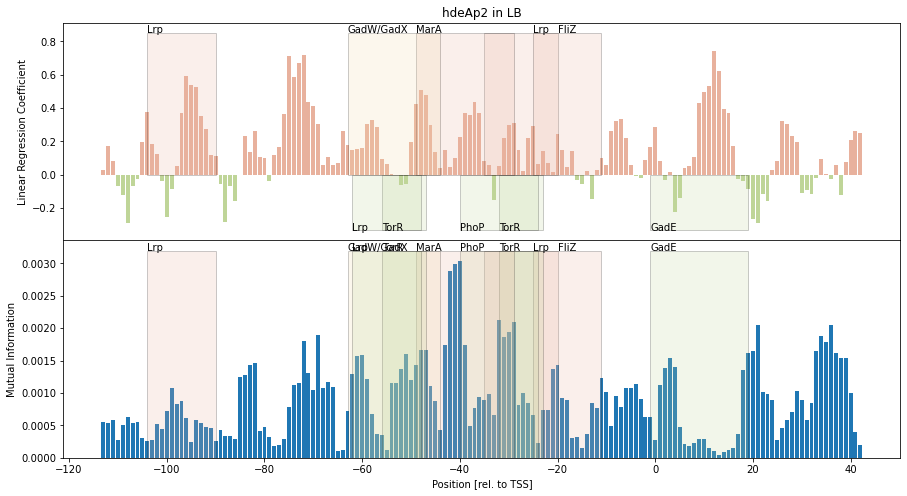

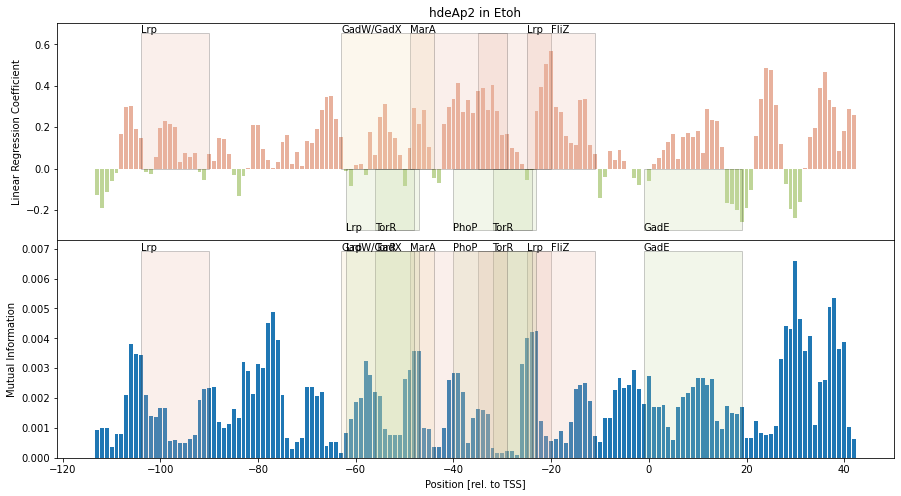

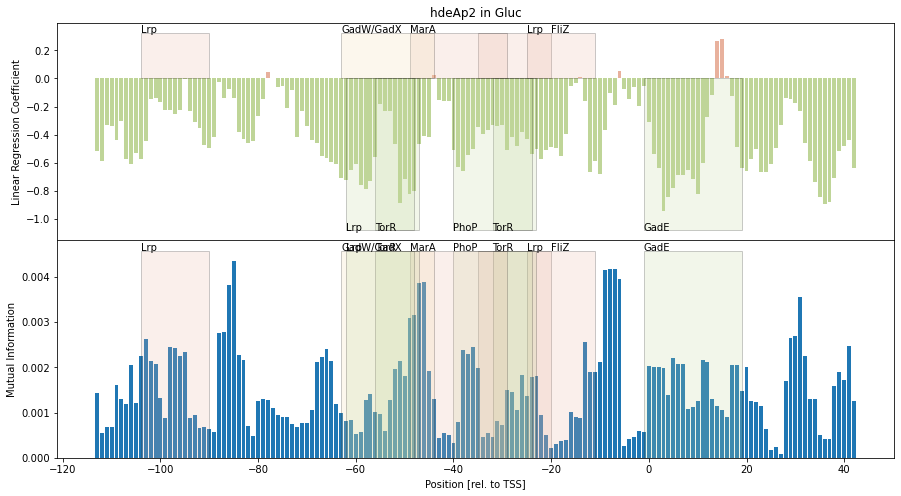

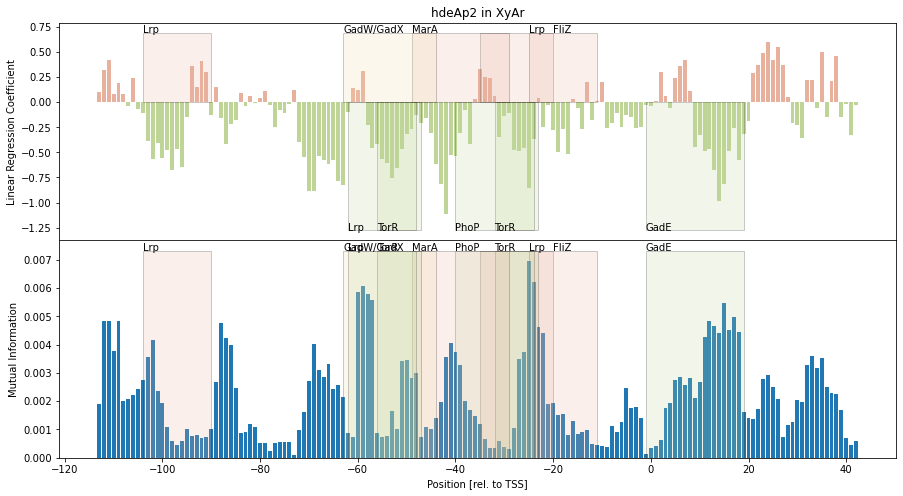

In [179]:
promoter = find_promoter("hdeA")
sites = [
    (-20, -35, "rep", "FliZ"),
    (-1, 19, "act", "GadE"),
    (-25, -11, "rep", "Lrp"),
    (-32, -23, "act", "TorR"),
    (-40, -24, "act", "PhoP"),
    (-49, -29, "rep", "MarA"),
    (-104, -90, "rep", "Lrp"),
    (-63, -44, "dual", "GadW/GadX"),
    (-56, -47, "act", "TorR"),
    (-62, -48, "act", "Lrp")
]
make_footprints(promoter, sites)

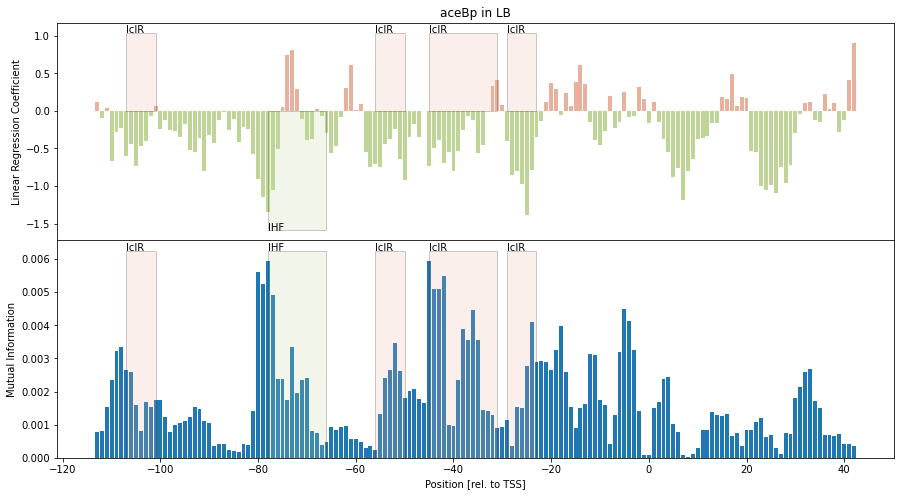

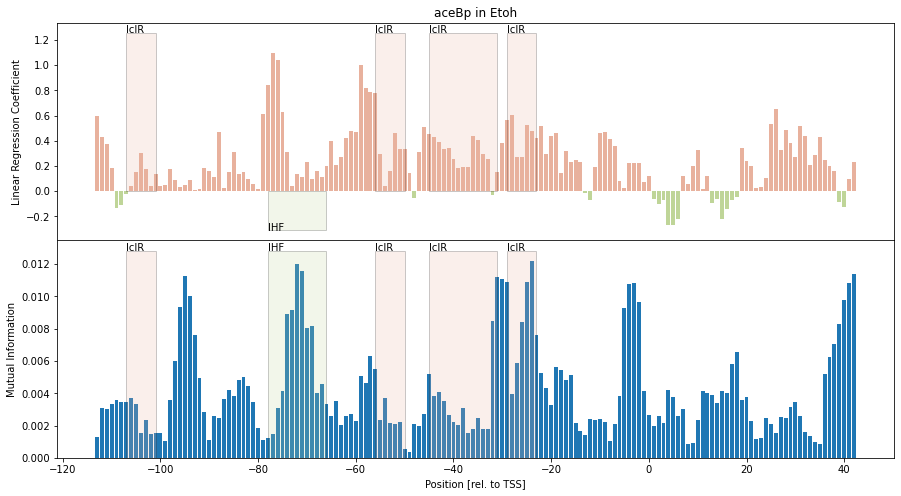

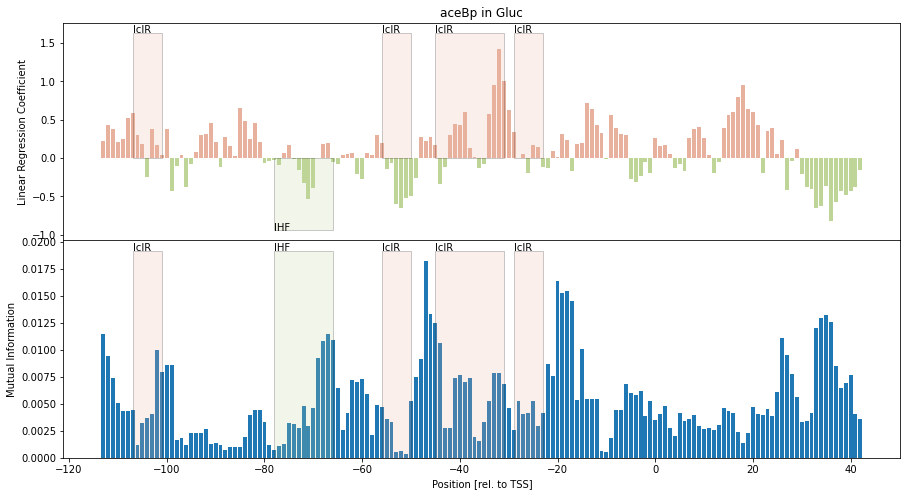

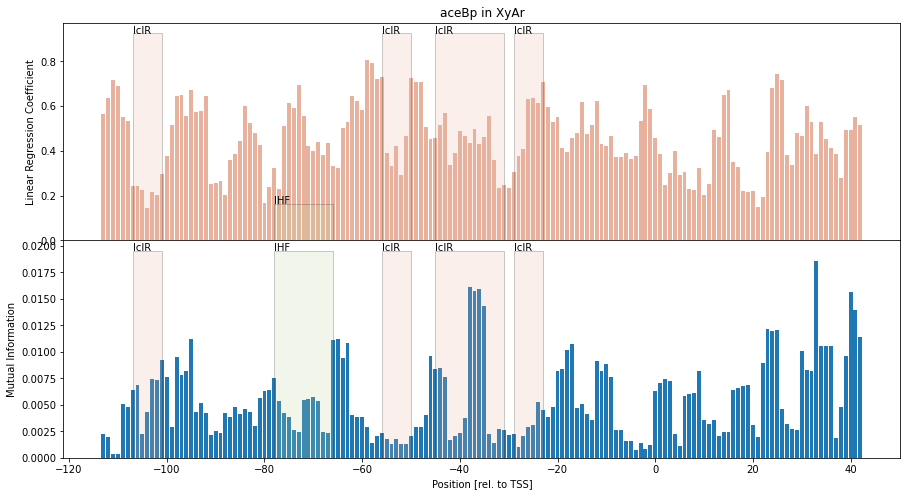

In [183]:
promoter = find_promoter("aceB")
sites = [
    (-29, -23, "rep", "IclR"),
    (-45, -31, "rep", "IclR"),
    (-56, -50, "rep", "IclR"),
    (-107, -101, "rep", "IclR"),
    (-78, -66, "act", "IHF"),
]
make_footprints(promoter, sites)

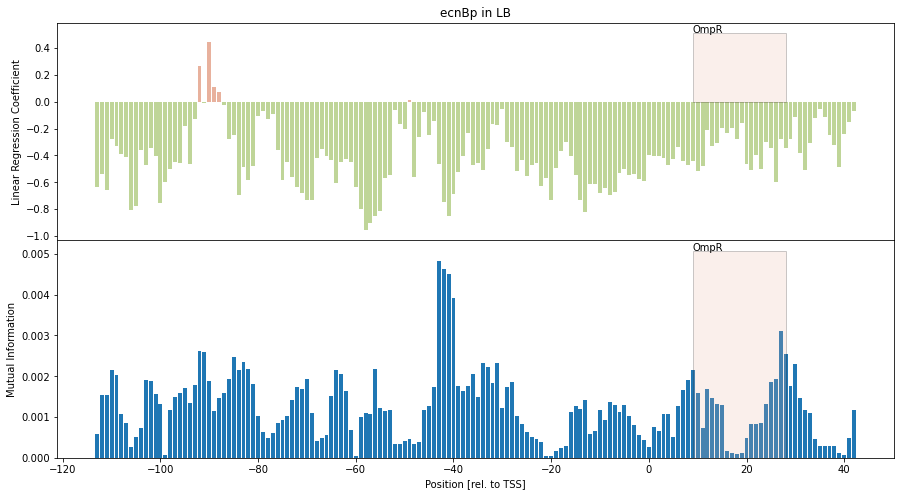

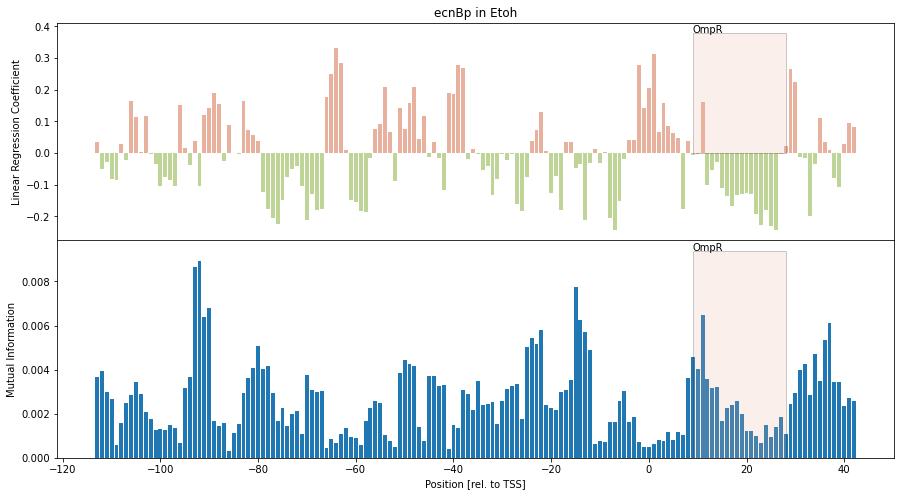

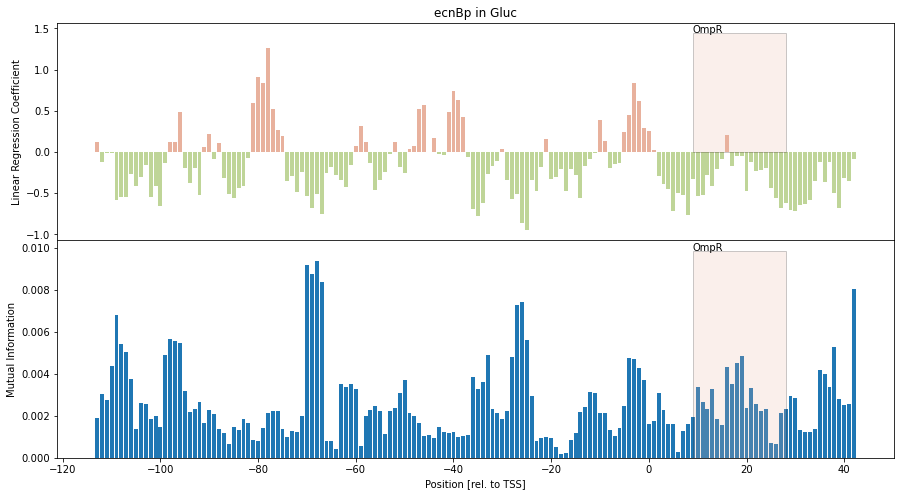

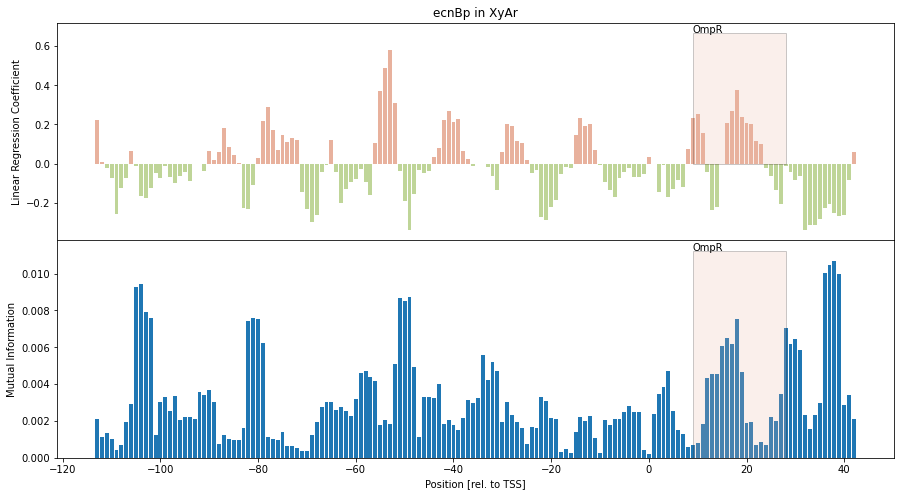

In [185]:
promoter = find_promoter("ecnB")

sites = [
    (9, 28, "rep", "OmpR"),
]

make_footprints(promoter, sites)